## Time Series Analysis - ARIMA Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# plt.style.use('seaborn-poster')
# plt.style.use('seaborn-whitegrid')
# plt.style.use('tableau-colorblind10')
plt.style.use('tableau-colorblind10')
# ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import boxcox, jarque_bera, probplot
from scipy.special import inv_boxcox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from pmdarima import auto_arima

from datetime import timedelta
from math import sqrt
import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define functions to fit an auto ARIMA model and generate predictions

def fit_autoARIMA(train):
    model = auto_arima(train.rename(None), trace=True, error_action='ignore', suppress_warnings=True) 
    model_fit = model.fit(train, transparams=False, disp=-1)
    return model_fit

def predict_autoARIMA(model_fit, test):
    predictions = model_fit.predict(n_periods=len(test))
    return predictions[0]

# Define function to plot actuals vs predictions

def plot_actuals_predictions(target, predictions_final, results_df):
    fig, ax = plt.subplots(figsize=(21,7))
    actuals = plt.plot(target, label='Actuals', color='tab:cyan')
    predictions = plt.plot(predictions_final, label='Predictions', color='lightpink')
    error = results_df['rmse'].mean()
    plt.legend(loc='best')
    plt.title('RMSE: %.2f'% error)
    plt.show()

# Define model evaluation function

def evaluate_forecast(target, predictions_final, model_name):
    results = {'models': model_name}
    results['r2_score'] = r2_score(target, predictions_final)
    results['mean_abs_error'] = mean_absolute_error(target, predictions_final)
    results['median_abs_error'] = median_absolute_error(target, predictions_final)
    results['mse'] = mean_squared_error(target, predictions_final)
    results['rmse'] = np.sqrt(results['mse'])
    return results

### Extracting the data

In [3]:
# Import the entire time series 

df_oct19 = pd.read_csv('ts_dataset.csv').set_index('last_reported_2').sort_index()
df_oct19.index = pd.to_datetime(df_oct19.index)

print(f'DF shape: {df_oct19.shape}')
df_oct19.head()

DF shape: (35564, 27)


,Unnamed: 0,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,name,lat,lon,altitude,post_code,capacity,year,month,day,day_of_week,hour,minute,second,IsWeekday,TimeSlice
last_reported_2,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-01 00:01:19,10422,183,28,27,1,0,1,1,1,1.569888e+09,True,IN_SERVICE,"C/ GAVÀ, 1",41.372338,2.141875,61.0,8908.0,28.0,2019,10,1,1,0,1,19,True,0
2019-10-01 00:01:36,10368,126,17,17,0,5,1,1,1,1.569888e+09,True,IN_SERVICE,PG. DE COLOM /VIA LAIETANA,41.380679,2.181775,5.0,8908.0,23.0,2019,10,1,1,0,1,36,True,0
2019-10-01 00:02:04,10568,331,0,0,0,30,1,1,1,1.569888e+09,True,IN_SERVICE,"C/ CASTELLNOU, 65",41.397060,2.128010,82.0,8908.0,31.0,2019,10,1,1,0,2,4,True,0
2019-10-01 00:02:36,10344,102,0,0,0,24,1,1,1,1.569888e+09,True,IN_SERVICE,"AV. DIAGONAL, 612",41.392252,2.142044,69.0,8908.0,24.0,2019,10,1,1,0,2,36,True,0
2019-10-01 00:05:59,10778,126,17,17,0,5,1,1,1,1.569888e+09,True,IN_SERVICE,PG. DE COLOM /VIA LAIETANA,41.380679,2.181775,5.0,8908.0,23.0,2019,10,1,1,0,5,59,True,0


In [4]:
df_oct19.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35564 entries, 2019-10-01 00:01:19 to 2019-10-31 22:55:21
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            35564 non-null  int64  
 1   station_id                            35564 non-null  int64  
 2   num_bikes_available                   35564 non-null  int64  
 3   num_bikes_available_types.mechanical  35564 non-null  int64  
 4   num_bikes_available_types.ebike       35564 non-null  int64  
 5   num_docks_available                   35564 non-null  int64  
 6   is_installed                          35564 non-null  int64  
 7   is_renting                            35564 non-null  int64  
 8   is_returning                          35564 non-null  int64  
 9   last_reported                         35564 non-null  float64
 10  is_charging_station                   35564 non

In [5]:
df_oct19_1 = df_oct19.copy()

In [6]:
df_oct19_1 = df_oct19_1.drop('Unnamed: 0', axis=1)
df_oct19_1.head()

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,name,lat,lon,altitude,post_code,capacity,year,month,day,day_of_week,hour,minute,second,IsWeekday,TimeSlice
last_reported_2,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-01 00:01:19,183,28,27,1,0,1,1,1,1.569888e+09,True,IN_SERVICE,"C/ GAVÀ, 1",41.372338,2.141875,61.0,8908.0,28.0,2019,10,1,1,0,1,19,True,0
2019-10-01 00:01:36,126,17,17,0,5,1,1,1,1.569888e+09,True,IN_SERVICE,PG. DE COLOM /VIA LAIETANA,41.380679,2.181775,5.0,8908.0,23.0,2019,10,1,1,0,1,36,True,0
2019-10-01 00:02:04,331,0,0,0,30,1,1,1,1.569888e+09,True,IN_SERVICE,"C/ CASTELLNOU, 65",41.397060,2.128010,82.0,8908.0,31.0,2019,10,1,1,0,2,4,True,0
2019-10-01 00:02:36,102,0,0,0,24,1,1,1,1.569888e+09,True,IN_SERVICE,"AV. DIAGONAL, 612",41.392252,2.142044,69.0,8908.0,24.0,2019,10,1,1,0,2,36,True,0
2019-10-01 00:05:59,126,17,17,0,5,1,1,1,1.569888e+09,True,IN_SERVICE,PG. DE COLOM /VIA LAIETANA,41.380679,2.181775,5.0,8908.0,23.0,2019,10,1,1,0,5,59,True,0


In [7]:
df_oct19_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35564 entries, 2019-10-01 00:01:19 to 2019-10-31 22:55:21
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   station_id                            35564 non-null  int64  
 1   num_bikes_available                   35564 non-null  int64  
 2   num_bikes_available_types.mechanical  35564 non-null  int64  
 3   num_bikes_available_types.ebike       35564 non-null  int64  
 4   num_docks_available                   35564 non-null  int64  
 5   is_installed                          35564 non-null  int64  
 6   is_renting                            35564 non-null  int64  
 7   is_returning                          35564 non-null  int64  
 8   last_reported                         35564 non-null  float64
 9   is_charging_station                   35564 non-null  bool   
 10  status                                35564 non

In [8]:
# Select data of interest

data_of_interest = ['num_bikes_available', 'num_bikes_available_types.mechanical', 'num_bikes_available_types.ebike', 'num_docks_available']

df_select = df_oct19_1[data_of_interest + ['station_id']]

print(f'The variables of interest are {len(data_of_interest)}: {data_of_interest}')
print('')

stations_of_interest = [331, 183, 126, 102]

print(f'The stations of interest are {len(stations_of_interest)}: {stations_of_interest}')
print('')

# Select data for the time period of interest

first_date = '2019-10-01 00:00:00'
last_date = '2019-10-28 23:59:59'

df_select = df_select.loc[first_date:last_date].sort_index()

print(f'The time period is from {first_date} to {last_date}')
print('')

# Inspect resulting dataframe

print(f'Filtered DF shape: {df_select.shape}')
df_select.head()

The variables of interest are 4: ['num_bikes_available', 'num_bikes_available_types.mechanical', 'num_bikes_available_types.ebike', 'num_docks_available']

The stations of interest are 4: [331, 183, 126, 102]

The time period is from 2019-10-01 00:00:00 to 2019-10-28 23:59:59

Filtered DF shape: (32160, 5)


,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,station_id
last_reported_2,,,,,
2019-10-01 00:01:19,28,27,1,0,183
2019-10-01 00:01:36,17,17,0,5,126
2019-10-01 00:02:04,0,0,0,30,331
2019-10-01 00:02:36,0,0,0,24,102
2019-10-01 00:05:59,17,17,0,5,126


## Prediction: Station 331

In [9]:
# Generate dataframe for one variable and one station of interest

var_interest = 'num_bikes_available'
station_of_interest = 331

var_station = df_select.loc[df_select['station_id'] == station_of_interest]
var_station = var_station.drop(columns = [x for x in data_of_interest if x is not var_interest], axis=1)
var_station.drop('station_id', axis=1, inplace=True)
# var_station.fillna(method='ffill', inplace=True)

var_station['weekday'] = var_station.index.weekday
var_station['year'] = var_station.index.year
var_station['month'] = var_station.index.month
var_station['day'] = var_station.index.day
var_station['hour'] = var_station.index.hour
var_station['minute'] = var_station.index.minute
var_station['second'] = var_station.index.minute
# var_station.fillna(0, inplace=True)

print(f'DF shape: {var_station.shape}')
print(f'Missing values: {var_station[var_interest].isnull().sum()}')
var_station.head()

DF shape: (8040, 8)
Missing values: 0


,num_bikes_available,weekday,year,month,day,hour,minute,second
last_reported_2,,,,,,,,
2019-10-01 00:02:04,0,1,2019,10,1,0,2,2
2019-10-01 00:06:26,0,1,2019,10,1,0,6,6
2019-10-01 00:10:48,0,1,2019,10,1,0,10,10
2019-10-01 00:19:32,0,1,2019,10,1,0,19,19
2019-10-01 00:23:54,1,1,2019,10,1,0,23,23


2019-10-13 00:00:00
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-260.527, BIC=-259.557, Time=0.031 seconds
Total fit time: 0.031 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-260.527, BIC=-259.557, Time=0.031 seconds
Total fit time: 0.031 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=72.314, BIC=75.223, Time=0.055 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=86.517, BIC=87.487, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=76.001, BIC=77.455, Time=0.015 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=77.334, BIC=78.789, Time=0.063 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=87.608, BIC=88.093, Time=0.005 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=70.425, BIC=72.849, Time=0.063 seconds
Fit AR

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=19.497, BIC=22.407, Time=0.201 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=20.006, BIC=20.975, Time=0.013 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=20.359, BIC=21.814, Time=0.014 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=21.170, BIC=22.625, Time=0.014 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=31.189, BIC=31.674, Time=0.010 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=25.064, BIC=27.488, Time=0.098 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=21.471, BIC=23.896, Time=0.167 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=21.046, BIC=24.440, Time=0.225 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=21.067, BIC=23.006, Time=0.056 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AI

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=15.130, BIC=18.039, Time=0.184 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=17.967, BIC=18.937, Time=0.013 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=11.030, BIC=12.485, Time=0.021 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=14.481, BIC=15.936, Time=0.021 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=19.419, BIC=19.904, Time=0.010 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=12.780, BIC=14.720, Time=0.027 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=12.868, BIC=14.808, Time=0.026 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=13.205, BIC=15.629, Time=0.108 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.415 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-260.527, BIC=-259.557, Time=0.026 seconds
Total fit time:

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=46.107, BIC=52.920, Time=0.156 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=41.767, BIC=44.038, Time=0.010 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=43.766, BIC=47.173, Time=0.017 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=43.766, BIC=47.173, Time=0.016 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=39.911, BIC=41.046, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=45.692, BIC=50.234, Time=0.054 seconds
Total fit time: 0.266 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=32.163, BIC=39.231, Time=0.043 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=34.261, BIC=36.618, Time=0.012 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=27.705, BIC=31.239, Time=0.016 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=26.822, BIC=30.356, Time=0.024 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; 

Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=33.978, BIC=41.047, Time=0.075 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=31.221, BIC=38.289, Time=0.137 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=31.533, BIC=40.957, Time=0.222 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 1.145 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=23.759, BIC=30.828, Time=0.150 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=18.998, BIC=21.354, Time=0.019 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=19.705, BIC=23.239, Time=0.017 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=19.101, BIC=22.636, Time=0.019 sec

Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=5.817, BIC=14.064, Time=0.178 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=11.361, BIC=16.074, Time=0.029 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=4.009, BIC=11.077, Time=0.164 seconds
Near non-invertible roots for order (1, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=11.188, BIC=18.256, Time=0.071 seconds
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=7.575, BIC=16.999, Time=0.187 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 1.222 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=71.114, BIC=77.927, Time=0.189 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=65.242, BIC=67.513, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=66.597, BIC=70.003, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=66.742, BIC=70.149, Time=0.015 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=64.057, BIC=65.192, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=68.394, BIC=72.936, Time=0.028 seconds
Total fit time: 0.270 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=76.393, BIC=83.461, Time=0.131 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=88.993, BIC=91.349, Time=0.007 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=73.698, BIC=77.232, Time=0.016 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=76.678, BIC=80.212, Time=0.019 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; 

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=29.363, BIC=36.431, Time=0.132 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=24.731, BIC=27.087, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=26.533, BIC=30.067, Time=0.013 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=26.558, BIC=30.092, Time=0.018 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=27.107, BIC=28.285, Time=0.009 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=28.457, BIC=33.169, Time=0.025 seconds
Total fit time: 0.215 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=15.533, BIC=22.601, Time=0.144 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=31.934, BIC=34.290, Time=0.013 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=12.767, BIC=16.301, Time=0.019 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=19.262, BIC=22.796, Time=0.025 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; 

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=89.646, BIC=96.459, Time=0.118 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=89.595, BIC=91.866, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=90.989, BIC=94.395, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=87.877, BIC=91.284, Time=0.021 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=90.447, BIC=91.582, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=87.448, BIC=91.990, Time=0.110 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=85.893, BIC=90.435, Time=0.097 seconds
Near non-invertible roots for order (0, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(1,1,2)x(0,0,0,

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=26.099, BIC=33.167, Time=0.101 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=34.261, BIC=36.618, Time=0.013 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=26.399, BIC=29.933, Time=0.016 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=31.097, BIC=34.631, Time=0.017 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=40.538, BIC=41.716, Time=0.009 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=24.830, BIC=30.721, Time=0.042 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=28.251, BIC=32.963, Time=0.038 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=26.593, BIC=31.306, Time=0.039 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=26.242, BIC=33.310, Time=0.052 seconds
Fit ARIMA(0,0,3)x(0,0,0,0) [intercept=True]; AIC=25.890, BIC=31.781, Time=0.038 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=27.032, BIC=32.922, Time=0.

Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=24.312, BIC=32.559, Time=0.176 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=25.184, BIC=33.430, Time=0.070 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=24.025, BIC=28.737, Time=0.025 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=23.187, BIC=30.256, Time=0.070 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=21.272, BIC=28.340, Time=0.161 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=26.843, BIC=36.268, Time=0.162 seconds
Total fit time: 1.002 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=5.973, BIC=13.042, Time=0.119 seco

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=127.758, BIC=133.649, Time=0.125 seconds
Total fit time: 0.395 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=95.768, BIC=102.581, Time=0.138 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=91.057, BIC=93.327, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=92.418, BIC=95.824, Time=0.013 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=92.292, BIC=95.699, Time=0.013 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=89.325, BIC=90.460, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=91.933, BIC=96.475, Time=0.109 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.289 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=79.541, BIC=86.354, Time=0.

Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=30.452, BIC=34.994, Time=0.115 seconds
Near non-invertible roots for order (0, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=31.899, BIC=37.577, Time=0.181 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 0.668 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=24.375, BIC=31.443, Time=0.219 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=38.671, BIC=41.027, Time=0.017 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=31.538, BIC=35.072, Time=0.019 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=23.892, BIC=27.426, Time=0.053 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 0, 0); setting score to inf (at

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=35.661, BIC=42.729, Time=0.124 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=50.998, BIC=53.354, Time=0.014 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=40.902, BIC=44.436, Time=0.022 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=35.409, BIC=38.943, Time=0.023 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=58.829, BIC=60.007, Time=0.006 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=34.312, BIC=39.025, Time=0.067 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=34.698, BIC=40.588, Time=0.039 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=34.019, BIC=39.910, Time=0.108 seconds
Near non-invertible roots for order (1, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=33.079, BIC=37.791, Time=0.025 seconds
Fit AR

Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=25.527, BIC=34.059, Time=0.164 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=27.739, BIC=36.271, Time=0.157 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=28.183, BIC=33.058, Time=0.026 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=28.634, BIC=35.948, Time=0.148 seconds
Near non-invertible roots for order (1, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=27.776, BIC=35.089, Time=0.086 seconds
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=27.420, BIC=37.171, Time=0.178 seconds
Total fit time: 1.121 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=41.003, BIC=48.071, Time=0.152 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=50.998, BIC=53.354, Time=0.014 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=40.902, BIC=44.4

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=51.390, BIC=54.796, Time=0.030 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=48.114, BIC=49.250, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=50.292, BIC=54.834, Time=0.090 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Total fit time: 0.306 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=48.583, BIC=55.396, Time=0.151 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=44.476, BIC=46.747, Time=0.007 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=46.465, BIC=49.871, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=46.463, BIC=49.870, Time=0.020 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=42.982, BIC=44.117, Time=0.010 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=45.708, BIC=50

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=14.081, BIC=16.991, Time=0.135 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=7.192, BIC=8.161, Time=0.012 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=9.082, BIC=10.536, Time=0.015 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=9.051, BIC=10.505, Time=0.016 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=6.236, BIC=6.721, Time=0.008 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=10.082, BIC=12.021, Time=0.096 seconds
Near non-invertible roots for order (1, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.287 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-260.527, BIC=-259.557, Time=0.027 seconds
Total fit time: 0.028 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=14.917, BIC=17.304, Time=0.132 s

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=49.505, BIC=55.599, Time=0.129 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=53.408, BIC=61.940, Time=0.147 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=48.929, BIC=57.461, Time=0.161 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=52.049, BIC=56.924, Time=0.025 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=48.329, BIC=55.642, Time=0.117 seconds
Near non-invertible roots for order (1, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=50.867, BIC=58.180, Time=0.048 second

Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=38.613, BIC=46.860, Time=0.158 seconds
Total fit time: 0.648 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=14.039, BIC=21.107, Time=0.178 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=37.289, BIC=39.645, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=13.731, BIC=17.266, Time=0.018 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=24.120, BIC=27.654, Time=0.021 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=46.569, BIC=47.747, Time=0.010 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=15.526, BIC=20.238, Time=0.028 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=15.566, BIC=20.278, Time=0.035 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=14.245, BIC=20.135, Time=0.125 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=180.399, BIC=189.557, Time=0.108 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=172.477, BIC=175.529, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=174.445, BIC=179.024, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=174.443, BIC=179.022, Time=0.017 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=171.485, BIC=173.011, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=175.247, BIC=181.353, Time=0.104 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.261 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=186.401, BIC=195.902, Time=0.145 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=180.134, BIC=183.301, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=47.763, BIC=58.848, Time=0.096 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=45.173, BIC=51.507, Time=0.086 seconds
Near non-invertible roots for order (1, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=46.508, BIC=56.009, Time=0.141 seconds
Near non-invertible roots for order (1, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=46.836, BIC=56.337, Time=0.130 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(3,0,3)

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=-15.869, BIC=-6.204, Time=0.128 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-1.012, BIC=2.210, Time=0.014 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-8.033, BIC=-3.200, Time=0.017 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=-21.261, BIC=-16.428, Time=0.028 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=-0.956, BIC=0.655, Time=0.009 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-19.267, BIC=-12.824, Time=0.056 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=-19.269, BIC=-12.825, Time=0.041 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=-17.864, BIC=-9.810, Time=0.129 seconds
Near non-invertible roots for order (1, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
Total fit time: 0.427 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=105.280, BIC=114.781, Time=0.166 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=130.486, BIC=133.653, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=105.575, BIC=110.326, Time=0.041 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=115.612, BIC=120.362, Time=0.015 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=320.923, BIC=322.506, Time=0.004 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=106.400, BIC=114.318, Time=0.117 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=108.840, BIC=116.758, Time=0.126 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=105.741, BIC=116.825, Time=0.200 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=105.420, BIC=116.505, Time=0.170 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [int

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=73.667, BIC=83.168, Time=0.145 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=74.580, BIC=77.747, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=70.801, BIC=75.551, Time=0.014 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=71.907, BIC=76.657, Time=0.013 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=88.035, BIC=89.618, Time=0.008 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=72.758, BIC=79.092, Time=0.019 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=72.776, BIC=79.110, Time=0.027 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=74.193, BIC=82.110, Time=0.107 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.352 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=64.630, BIC=73.

Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=78.917, BIC=82.084, Time=0.014 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=60.109, BIC=64.860, Time=0.020 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=62.150, BIC=66.900, Time=0.021 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=89.567, BIC=91.150, Time=0.012 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=60.695, BIC=67.029, Time=0.021 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=60.995, BIC=67.329, Time=0.026 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=60.000, BIC=67.918, Time=0.114 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.308 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=30.816, BIC=40.148, Time=0.161 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=88.149, BIC=91.

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=36.895, BIC=41.646, Time=0.017 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=36.894, BIC=41.645, Time=0.025 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=33.097, BIC=34.680, Time=0.011 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=37.541, BIC=43.875, Time=0.112 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.259 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=33.127, BIC=42.628, Time=0.174 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=56.146, BIC=59.313, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=33.259, BIC=38.009, Time=0.032 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=40.117, BIC=44.868, Time=0.018 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=81.157, BIC=82

Fit ARIMA(0,0,3)x(0,0,0,0) [intercept=True]; AIC=20.063, BIC=27.981, Time=0.064 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=20.961, BIC=28.879, Time=0.045 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=18.181, BIC=29.266, Time=0.147 seconds
Total fit time: 0.590 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=45.204, BIC=54.705, Time=0.150 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=48.335, BIC=51.502, Time=0.017 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=47.024, BIC=51.774, Time=0.018 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=47.746, BIC=52.496, Time=0.127 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=58.050, BIC=59.633, Time=0.009 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=44.445, BIC=52.362, Time=0.083 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=48.572, BIC=54.907, Time=0.045 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; A

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.015, BIC=23.237, Time=0.212 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.456 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=20.475, BIC=29.976, Time=0.122 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=45.900, BIC=49.067, Time=0.014 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=24.201, BIC=28.952, Time=0.018 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=31.460, BIC=36.211, Time=0.019 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=54.257, BIC=55.840, Time=0.009 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=18.499, BIC=26.416, Time=0.115 seconds
Near non-invertible roots for order (1, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=104.794, BIC=109.460, Time=0.021 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=101.326, BIC=102.881, Time=0.008 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=104.636, BIC=110.858, Time=0.104 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.314 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=99.184, BIC=108.685, Time=0.143 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=157.433, BIC=160.600, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=98.319, BIC=103.069, Time=0.016 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=127.548, BIC=132.299, Time=0.016 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=181.673, BIC=183.257, Time=0.009 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=

Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=24.316, BIC=33.648, Time=0.133 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=24.077, BIC=33.410, Time=0.085 seconds
Fit ARIMA(3,1,3)x(0,0,0,0) [intercept=True]; AIC=28.005, BIC=40.448, Time=0.205 seconds
Total fit time: 1.287 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=60.380, BIC=69.712, Time=0.048 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=54.777, BIC=57.888, Time=0.009 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=54.410, BIC=59.076, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=54.531, BIC=59.197, Time=0.021 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=53.791, BIC=55.347, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=56.409, BIC=62.630, Time=0.044 seconds
Total fit time: 0.148 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=70.687, BIC=

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=57.981, BIC=67.313, Time=0.156 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=65.860, BIC=68.971, Time=0.021 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=66.813, BIC=71.479, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=65.635, BIC=70.301, Time=0.020 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=63.860, BIC=65.416, Time=0.007 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=59.701, BIC=67.478, Time=0.188 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=56.009, BIC=63.786, Time=0.122 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=59.155, BIC=70.043

Fit ARIMA(3,1,3)x(0,0,0,0) [intercept=True]; AIC=41.479, BIC=53.689, Time=0.219 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 1.547 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=55.315, BIC=64.816, Time=0.166 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=52.017, BIC=55.184, Time=0.014 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=53.386, BIC=58.136, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=53.396, BIC=58.146, Time=0.041 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=50.017, BIC=51.600, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=55.381, BIC=61.715, Time=0.041 seconds
Total fit time: 0.288 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=26.682, BIC=36.183, Time=0.143

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=27.421, BIC=36.754, Time=0.131 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=35.018, BIC=38.129, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=35.527, BIC=40.193, Time=0.019 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=33.536, BIC=38.202, Time=0.021 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=33.219, BIC=34.774, Time=0.006 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=25.591, BIC=33.368, Time=0.179 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=31.125, BIC=38.902, Time=0.131 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(3,1,2)x(0,0,0,

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=15.808, BIC=22.621, Time=0.175 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=35.151, BIC=37.422, Time=0.018 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=14.162, BIC=17.568, Time=0.018 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=22.641, BIC=26.047, Time=0.023 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=57.440, BIC=58.575, Time=0.007 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=15.927, BIC=20.469, Time=0.026 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=15.977, BIC=20.519, Time=0.029 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=14.662, BIC=20.340, Time=0.152 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Total fit time: 0.452 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=14.563, BIC=21.

Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=-3.238, BIC=0.296, Time=0.032 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=-6.164, BIC=-4.986, Time=0.010 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-2.988, BIC=1.724, Time=0.095 seconds
Near non-invertible roots for order (1, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.320 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=3.804, BIC=10.872, Time=0.138 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=10.383, BIC=12.739, Time=0.013 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=7.102, BIC=10.637, Time=0.017 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=-0.866, BIC=2.668, Time=0.058 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=-2.879, BIC=6.622, Time=0.134 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=22.823, BIC=25.990, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-0.550, BIC=4.200, Time=0.060 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=3.126, BIC=7.877, Time=0.041 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=25.063, BIC=26.647, Time=0.009 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=-0.339, BIC=7.578, Time=0.057 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=-0.744, BIC=7.174, Time=0.128 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=-2.204, BIC=8.881, Time=0.161 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=137.999, BIC=147.331, Time=0.157 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=153.383, BIC=156.494, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=140.004, BIC=144.670, Time=0.019 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=144.329, BIC=148.995, Time=0.015 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=204.486, BIC=206.042, Time=0.004 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=142.300, BIC=150.077, Time=0.046 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=136.948, BIC=144.725, Time=0.119 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=140.687, BIC=151.575, Time=0.181 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to in

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=41.519, BIC=51.020, Time=0.086 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=50.354, BIC=53.521, Time=0.014 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=36.545, BIC=41.296, Time=0.017 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=39.488, BIC=44.238, Time=0.023 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=61.481, BIC=63.065, Time=0.011 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=38.485, BIC=44.820, Time=0.027 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=38.480, BIC=44.814, Time=0.054 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=38.962, BIC=46.880, Time=0.116 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Total fit time: 0.351 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=-14.923, BIC=-5.422, Time=0.148 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=0.052, BIC=3.220, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-19.762, BIC=-15.012, Time=0.029 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=-20.073, BIC=-15.323, Time=0.062 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=0.110, BIC=1.694, Time=0.012 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-18.884, BIC=-12.549, Time=0.049 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=-18.885, BIC=-12.551, Time=0.069 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=-16.911, BIC=-8.994, Time=0.099 seconds
Total fit time: 0.487 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=23.417, BIC=32.918, Time=0.075 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=56.146, BIC=59.313, Time=0.020 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=Tr

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=243.215, BIC=254.316, Time=0.119 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=239.246, BIC=242.946, Time=0.005 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=241.016, BIC=246.567, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=240.948, BIC=246.499, Time=0.016 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=237.865, BIC=239.716, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=239.401, BIC=246.802, Time=0.081 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.247 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=233.495, BIC=244.596, Time=0.158 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=229.463, BIC=233.163, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=60.171, BIC=73.269, Time=0.136 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=58.690, BIC=71.788, Time=0.171 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=57.102, BIC=64.587, Time=0.033 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=56.694, BIC=67.922, Time=0.161 seconds
Near non-invertible roots for order (1, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=57.539, BIC=68.766, Time=0.161 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=56.092, BIC=71.062, Time=0.187 second

Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-37.973, BIC=-30.572, Time=0.062 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=-37.052, BIC=-27.801, Time=0.154 seconds
Total fit time: 0.582 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=276.998, BIC=288.225, Time=0.092 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=321.586, BIC=325.328, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=273.603, BIC=279.217, Time=0.014 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=291.369, BIC=296.982, Time=0.017 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=325.995, BIC=327.866, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=275.092, BIC=282.576, Time=0.022 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=275.200, BIC=282.685, Time=0.026 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=274.282, BIC=283.638, Time=0.128 seconds
Near non-invertible roots 

Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=143.767, BIC=157.010, Time=0.182 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=140.811, BIC=148.379, Time=0.027 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=142.306, BIC=153.657, Time=0.042 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=136.031, BIC=147.382, Time=0.166 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=139.648, BIC=154.782, Time=0.200 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 1.157 seconds
Performing stepwise search to minimize aic
Fit

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=64.814, BIC=76.041, Time=0.166 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=73.341, BIC=77.084, Time=0.017 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=62.143, BIC=67.757, Time=0.015 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=63.287, BIC=68.900, Time=0.017 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=79.075, BIC=80.946, Time=0.008 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=63.517, BIC=71.002, Time=0.025 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=63.635, BIC=71.120, Time=0.027 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=62.576, BIC=71.932, Time=0.126 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Total fit time: 0.405 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=96.552, BIC=107

Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=81.046, BIC=92.274, Time=0.067 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=76.065, BIC=87.292, Time=0.161 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=77.276, BIC=92.245, Time=0.188 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 1.141 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=39.621, BIC=50.721, Time=0.113 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=104.353, BIC=108.054, Time=0.011 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=34.196, BIC=39.747, Time=0.026 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=69.535, BIC=75.086, Time=0.018 s

Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=306.036, BIC=311.649, Time=0.033 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=407.377, BIC=409.249, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=272.945, BIC=280.430, Time=0.024 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=272.956, BIC=280.441, Time=0.027 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=271.973, BIC=281.329, Time=0.127 seconds
Total fit time: 0.390 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=242.920, BIC=253.892, Time=0.201 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=236.248, BIC=239.905, Time=0.007 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=238.172, BIC=243.658, Time=0.019 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=238.174, BIC=243.660, Time=0.017 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=234.713, BIC=236.541, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0

Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=44.482, BIC=53.838, Time=0.083 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=50.347, BIC=57.832, Time=0.029 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=50.082, BIC=57.566, Time=0.043 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=46.481, BIC=57.709, Time=0.081 seconds
Fit ARIMA(0,0,3)x(0,0,0,0) [intercept=True]; AIC=49.114, BIC=58.470, Time=0.047 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=48.654, BIC=58.010, Time=0.103 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=47.936, BIC=61.034, Time=0.102 seconds
Total fit time: 0.684 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=75.130, BIC=86.357, Time=0.125 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=101.620, BIC=105.363, Time=0.013 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=71.597, BIC=77.211, Time=0.017 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; 

Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=12.475, BIC=25.573, Time=0.187 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=18.038, BIC=25.523, Time=0.034 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=10.488, BIC=21.715, Time=0.145 seconds
Near non-invertible roots for order (1, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=19.559, BIC=30.786, Time=0.078 seconds
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=14.432, BIC=29.401, Time=0.183 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Total fit time: 1.279 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-1054.1

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=131.538, BIC=142.766, Time=0.056 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=177.781, BIC=181.523, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=132.090, BIC=137.703, Time=0.016 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=152.410, BIC=158.024, Time=0.019 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=193.230, BIC=195.101, Time=0.009 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=131.269, BIC=140.625, Time=0.032 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=133.013, BIC=140.498, Time=0.027 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=133.309, BIC=140.794, Time=0.023 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=132.771, BIC=143.998, Time=0.041 seconds
Fit ARIMA(0,0,3)x(0,0,0,0) [intercept=True]; AIC=133.627, BIC=142.983, Time=0.037 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=134.097, BIC=143.453, Time=0.087 seconds
Fit ARIMA

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=111.062, BIC=120.418, Time=0.071 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=105.821, BIC=118.919, Time=0.168 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=107.354, BIC=120.453, Time=0.173 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=114.669, BIC=125.896, Time=0.046 seconds
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=107.738, BIC=122.707, Time=0.213 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA(2,0,4)x(0,0,0,0) [intercept=True]; AIC=107.036, BIC=122.005, Time=0.194 seconds
Near non-invertible roots for order (2, 0, 4)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit c

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=41.117, BIC=50.576, Time=0.151 seconds
Total fit time: 0.438 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=-12.166, BIC=-0.939, Time=0.176 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=33.995, BIC=37.738, Time=0.023 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-13.987, BIC=-8.374, Time=0.020 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=3.798, BIC=9.412, Time=0.036 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=38.405, BIC=40.276, Time=0.009 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=-12.499, BIC=-5.014, Time=0.032 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-12.390, BIC=-4.906, Time=0.040 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=-13.308, BIC=-3.952, Time=0.147 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border 

Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=26.373, BIC=30.116, Time=0.019 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=11.252, BIC=16.865, Time=0.029 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=19.145, BIC=24.759, Time=0.021 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=29.653, BIC=31.525, Time=0.013 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=6.387, BIC=15.743, Time=0.061 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=5.981, BIC=13.466, Time=0.033 seconds
Fit ARIMA(0,0,3)x(0,0,0,0) [intercept=True]; AIC=7.314, BIC=16.670, Time=0.133 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=9.866, BIC=17.351, Time=0.043 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=8.017, BIC=19.244, Time=0.106 seconds
Total fit time: 0.523 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-1054.109, BIC=-1050.366, Time=0.036 seconds
Total fit time: 0.036 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2

Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=70.394, BIC=79.645, Time=0.072 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=68.401, BIC=75.801, Time=0.039 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=70.385, BIC=79.636, Time=0.055 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=73.204, BIC=80.605, Time=0.070 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=69.912, BIC=81.013, Time=0.142 seconds
Total fit time: 0.545 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=79.383, BIC=90.611, Time=0.073 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=138.088, BIC=141.831, Time=0.016 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=74.837, BIC=80.450, Time=0.029 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=106.015, BIC=111.629, Time=0.035 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=160.276, BIC=162.147, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=Tr

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=62.255, BIC=70.309, Time=0.038 seconds
Total fit time: 0.194 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=53.532, BIC=63.033, Time=0.161 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=79.094, BIC=82.261, Time=0.024 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=50.711, BIC=55.461, Time=0.025 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=59.658, BIC=64.408, Time=0.056 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=91.036, BIC=92.620, Time=0.009 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=52.081, BIC=58.415, Time=0.044 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=52.261, BIC=58.596, Time=0.033 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=53.910, BIC=61.828, Time=0.121 seconds
Total fit time: 0.478 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=-15.072, BIC

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=-17.164, BIC=-7.663, Time=0.454 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-23.857, BIC=-20.690, Time=0.021 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-21.888, BIC=-17.137, Time=0.027 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=-21.890, BIC=-17.139, Time=0.058 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=-24.843, BIC=-23.260, Time=0.017 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-21.162, BIC=-14.828, Time=0.304 seconds
Near non-invertible roots for order (1, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.887 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=9.176, BIC=18.677, Time=0.533 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=22.823, BIC=25.990, Time=0.027 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=17.45

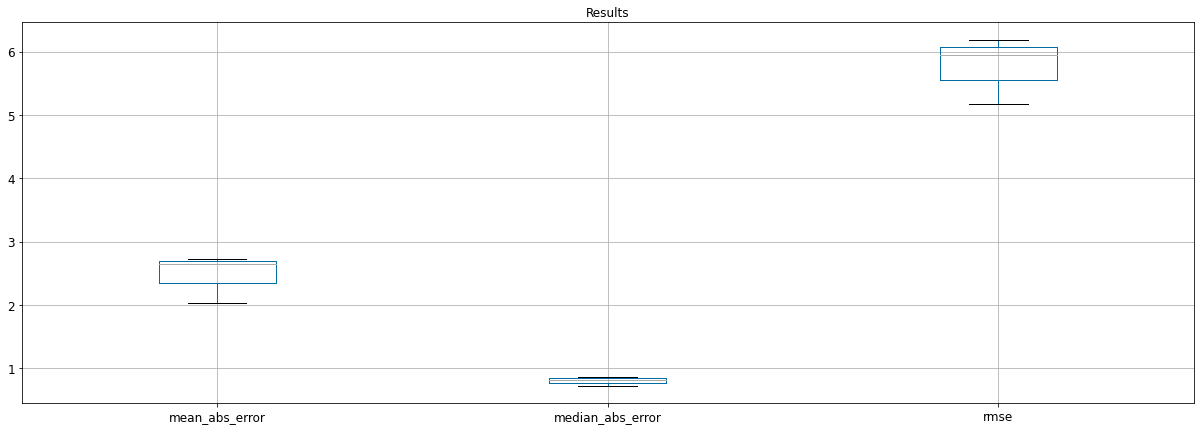

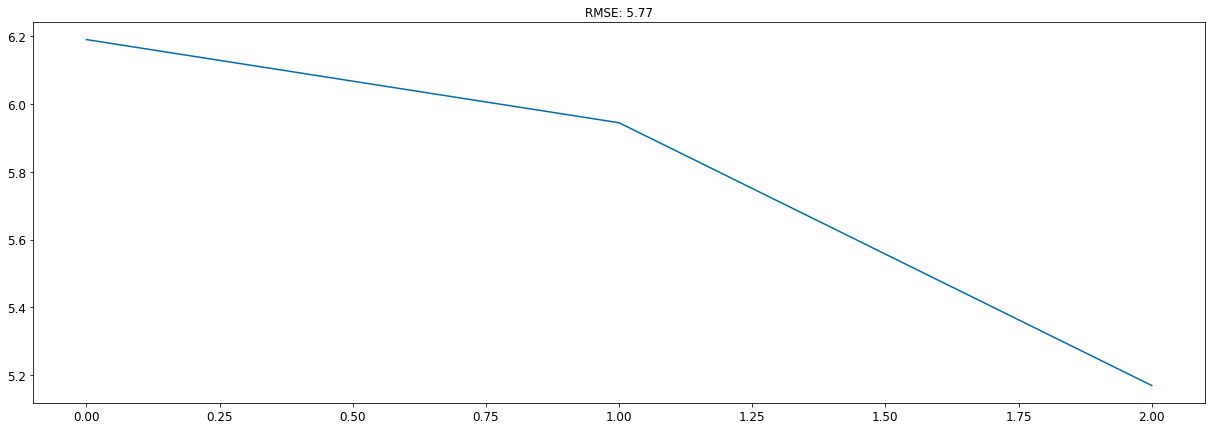

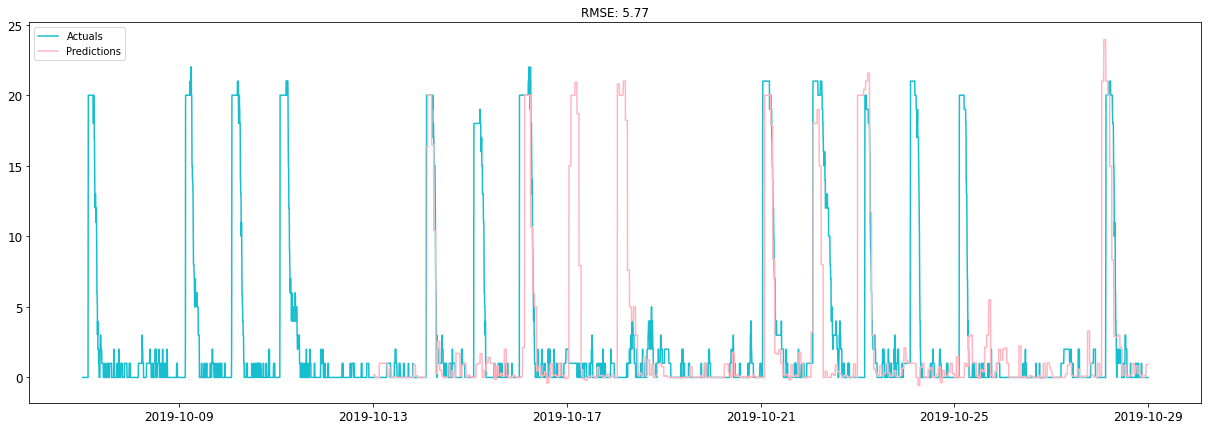

In [10]:
# Generate rolling predictions and results for particle of interest

data = var_station.sort_index().copy()
target = var_interest

fit_func = fit_autoARIMA
predict_func = predict_autoARIMA

min_train_date = '2019-10-07'

week_starts = pd.date_range(min_train_date, data.index.max(), freq='W')

predictions_over_time, results_over_time = [], []

for i, week_start in enumerate(week_starts):
    if i % 10 == 0:
        print(week_start)

    train_set = data.loc[:(week_start - timedelta(hours=1))]
    test_set = data.loc[week_start:(week_start + timedelta(weeks=1, hours=-1))]
    models = train_set.groupby(['weekday', 'hour'])[target].apply(fit_func)
    predictions = test_set.apply(lambda x: predict_func(models.loc[tuple(x[['weekday', 'hour']])], x), axis=1)
    predictions_over_time.append(predictions)    
    results = evaluate_forecast(test_set[target], predictions, 'none')
    results['date'] = week_start
    results_over_time.append(results)  

results_over_time_08 = pd.DataFrame(results_over_time)
predictions_over_time_08 = pd.concat(predictions_over_time)

# Plot results statistics

results_over_time = results_over_time_08

fig, ax = plt.subplots(figsize=(21,7))
results_over_time.drop(['r2_score', 'mse'], axis=1).boxplot()
plt.title('Results')
plt.show()

# Plot RMSE overtime

fig, ax = plt.subplots(figsize=(21,7))
rmse_over_time = plt.plot(results_over_time['rmse'])
error = results_over_time['rmse'].mean()
plt.title('RMSE: %.2f'% error)
plt.show()

# Plot actuals and predictions overtime

plot_actuals_predictions(var_station[var_interest][min_train_date:], predictions_over_time_08, results_over_time_08)

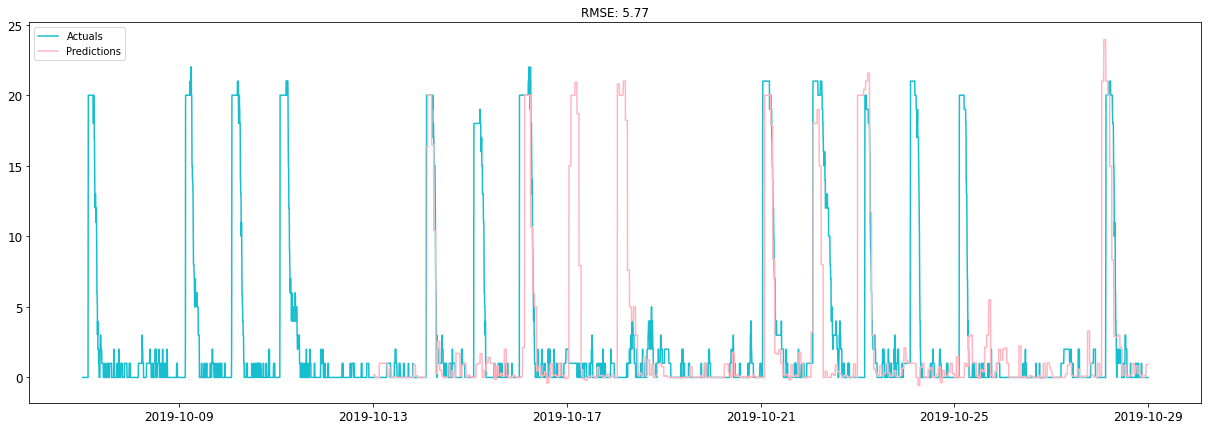

In [11]:
plot_actuals_predictions(var_station[var_interest][min_train_date:], predictions_over_time_08, results_over_time_08)

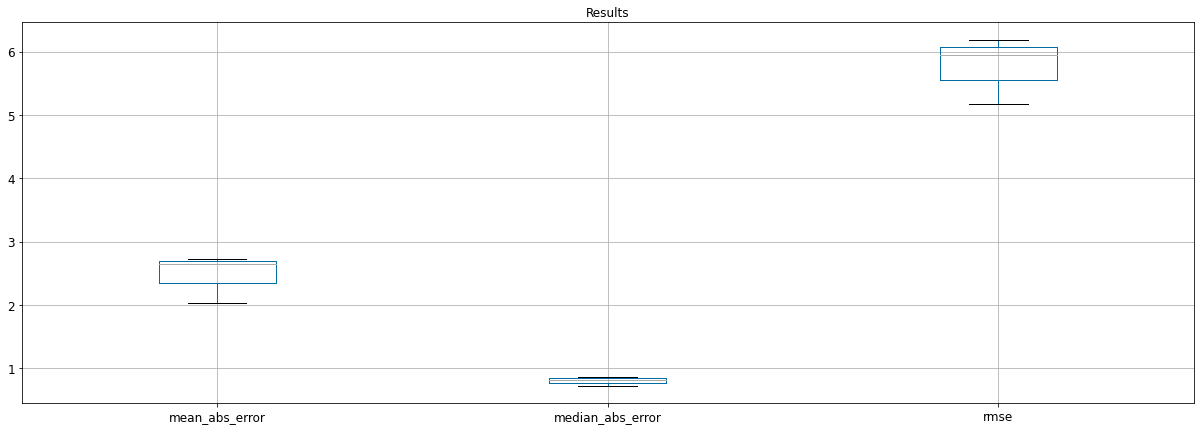

In [12]:
fig, ax = plt.subplots(figsize=(21,7))
results_over_time.drop(['r2_score', 'mse'], axis=1).boxplot()
plt.title('Results')
plt.show()

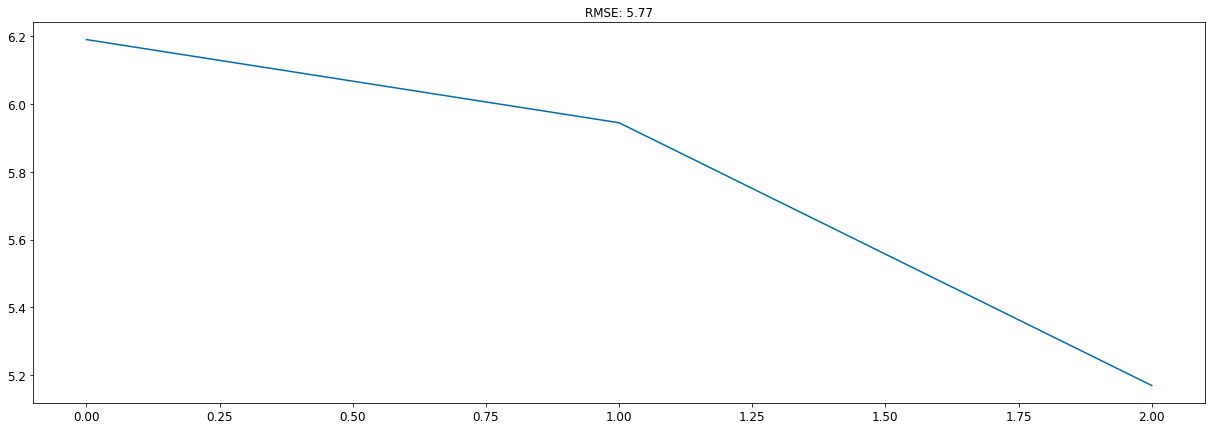

In [13]:
fig, ax = plt.subplots(figsize=(21,7))
rmse_over_time = plt.plot(results_over_time['rmse'])
error = results_over_time['rmse'].mean()
plt.title('RMSE: %.2f'% error)
plt.show()

In [14]:
results_over_time_08

,models,r2_score,mean_abs_error,median_abs_error,mse,rmse,date
0,none,-0.304527,2.722687,0.727273,38.309102,6.189435,2019-10-13
1,none,0.194398,2.650546,0.865348,35.334348,5.944270,2019-10-20
2,none,0.122668,2.035396,0.821042,26.727455,5.169860,2019-10-27


## Prediction: Station 183

In [15]:
# Generate dataframe for one variable and one station of interest

var_interest = 'num_bikes_available'
station_of_interest = 183

var_station = df_select.loc[df_select['station_id'] == station_of_interest]
var_station = var_station.drop(columns = [x for x in data_of_interest if x is not var_interest], axis=1)
var_station.drop('station_id', axis=1, inplace=True)
# var_station.fillna(method='ffill', inplace=True)

# var_station['quarter'] = var_station.index.quarter
# var_station['dayofyear'] = var_station.index.dayofyear
# var_station['dayofmonth'] = var_station.index.day
# var_station['weekyear'] = var_station.index.weekofyear
var_station['weekday'] = var_station.index.weekday
var_station['year'] = var_station.index.year
var_station['month'] = var_station.index.month
var_station['day'] = var_station.index.day
var_station['hour'] = var_station.index.hour
var_station['minute'] = var_station.index.minute
var_station['second'] = var_station.index.minute
# var_station.fillna(0, inplace=True)

print(f'DF shape: {var_station.shape}')
print(f'Missing values: {var_station[var_interest].isnull().sum()}')
var_station.head()

DF shape: (8040, 8)
Missing values: 0


,num_bikes_available,weekday,year,month,day,hour,minute,second
last_reported_2,,,,,,,,
2019-10-01 00:01:19,28,1,2019,10,1,0,1,1
2019-10-01 00:10:18,28,1,2019,10,1,0,10,10
2019-10-01 00:14:41,28,1,2019,10,1,0,14,14
2019-10-01 00:19:02,28,1,2019,10,1,0,19,19
2019-10-01 00:23:22,28,1,2019,10,1,0,23,23


2019-10-13 00:00:00
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=34.727, BIC=38.117, Time=0.255 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=40.181, BIC=41.311, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=28.628, BIC=30.323, Time=0.050 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=34.489, BIC=36.184, Time=0.021 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=120.698, BIC=121.263, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=30.504, BIC=32.764, Time=0.062 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=30.531, BIC=32.791, Time=0.123 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=32.622, BIC=35.447, Time=0.141 seconds
Total fit time: 0.675 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-260.527, BIC=-259.557, Time=0.032 seconds
Total fit time: 0.033 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-260.527, BIC=-259.557, Time=

Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Total fit time: 1.116 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=52.333, BIC=55.242, Time=0.125 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=64.964, BIC=65.934, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=55.702, BIC=57.157, Time=0.015 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=55.579, BIC=57.033, Time=0.037 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=76.735, BIC=77.220, Time=0.004 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=52.036, BIC=54.460, Time=0.098 seconds
Near non-invertible roots for order (1, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fi

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=43.186, BIC=46.096, Time=0.170 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=35.460, BIC=36.430, Time=0.014 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=35.434, BIC=36.889, Time=0.041 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=34.547, BIC=36.001, Time=0.016 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=114.416, BIC=114.901, Time=0.004 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=36.541, BIC=38.481, Time=0.078 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=36.538, BIC=38.477, Time=0.022 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=38.884, BIC=41.309, Time=0.136 seconds
Near non-invertible roots for order (1, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
Total fit time: 0.485 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=21.645, BIC=2

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=4.140, BIC=11.208, Time=0.135 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=18.998, BIC=21.354, Time=0.013 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-0.963, BIC=2.572, Time=0.025 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=8.707, BIC=12.241, Time=0.029 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=20.202, BIC=21.381, Time=0.011 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=0.782, BIC=5.494, Time=0.051 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=0.850, BIC=5.562, Time=0.100 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=1.515, BIC=7.405, Time=0.135 seconds
Total fit time: 0.504 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=27.636, BIC=34.705, Time=0.059 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=28.856, BIC=31.212, Time=0.016 seconds
Fit ARIMA(1,

Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=82.036, BIC=85.443, Time=0.033 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=218.803, BIC=219.938, Time=0.006 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=82.023, BIC=86.565, Time=0.031 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=82.282, BIC=86.824, Time=0.030 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=81.620, BIC=87.297, Time=0.120 seconds
Total fit time: 0.416 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=36.939, BIC=44.253, Time=0.098 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=36.449, BIC=38.887, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=33.343, BIC=37.000, Time=0.018 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=34.932, BIC=38.589, Time=0.028 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=239.278, BIC=240.496, Time=0.005 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=Tru

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=56.416, BIC=63.485, Time=0.217 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=57.317, BIC=59.674, Time=0.122 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=59.140, BIC=62.675, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=59.151, BIC=62.685, Time=0.020 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=55.395, BIC=56.573, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=60.176, BIC=64.889, Time=0.051 seconds
Total fit time: 0.437 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=46.447, BIC=53.260, Time=0.135 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=48.456, BIC=50.727, Time=0.011 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=47.360, BIC=50.766, Time=0.017 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=41.892, BIC=45.298, Time=0.018 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; 

Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-4.591, BIC=-0.934, Time=0.043 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=-4.596, BIC=-0.939, Time=0.066 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=239.487, BIC=240.706, Time=0.004 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-2.580, BIC=2.295, Time=0.049 seconds
Total fit time: 0.327 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=2.776, BIC=9.845, Time=0.116 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-5.186, BIC=-2.830, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-3.233, BIC=0.301, Time=0.038 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=-3.238, BIC=0.296, Time=0.025 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=229.985, BIC=231.163, Time=0.004 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-1.222, BIC=3.491, Time=0.071 seconds
Total fit time: 0.272 seconds
Performing stepwi

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=35.940, BIC=43.008, Time=0.141 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=48.458, BIC=50.814, Time=0.011 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=37.927, BIC=41.461, Time=0.015 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=38.542, BIC=42.077, Time=0.016 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=66.904, BIC=68.082, Time=0.008 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=40.613, BIC=46.503, Time=0.045 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=35.211, BIC=41.101, Time=0.125 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=39.129, BIC=47.375, Time=0.152 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=105.482, BIC=112.551, Time=0.136 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=115.708, BIC=118.064, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=106.857, BIC=110.391, Time=0.027 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=108.204, BIC=111.738, Time=0.016 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=201.897, BIC=203.075, Time=0.004 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=108.816, BIC=114.706, Time=0.032 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=106.094, BIC=111.984, Time=0.116 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=110.200, BIC=118.447, Time=0.154 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=112.159, BIC=120.405, Time=0.142 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=107.656, BIC=112.368, Time=0.025 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=111.068, BIC=118.136, Time=0.092 seconds
Fit ARIMA

Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=111.055, BIC=116.946, Time=0.137 seconds
Total fit time: 0.415 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=108.053, BIC=114.866, Time=0.143 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=102.051, BIC=104.322, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=104.001, BIC=107.408, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=103.996, BIC=107.402, Time=0.013 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=101.074, BIC=102.209, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=104.054, BIC=108.596, Time=0.116 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.301 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=97.635, BIC=104.

Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=53.967, BIC=57.501, Time=0.032 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=71.089, BIC=72.267, Time=0.004 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=46.553, BIC=52.443, Time=0.046 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=49.905, BIC=55.795, Time=0.057 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=49.680, BIC=57.927, Time=0.128 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=45.096, BIC=53.343, Time=0.134 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=47.942, BIC=52.654, Time=0.034 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=44.793, BIC=51.861

Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=63.887, BIC=70.700, Time=0.249 seconds
Near non-invertible roots for order (3, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(3,1,3)x(0,0,0,0) [intercept=True]; AIC=65.553, BIC=74.637, Time=0.247 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 1.561 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=81.639, BIC=88.707, Time=0.154 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=95.255, BIC=97.611, Time=0.007 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=85.574, BIC=89.108, Time=0.049 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=88.818, BIC=92.352, Time=0.016 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=220.818, BIC=221.996, Time=0.004 

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=71.820, BIC=78.633, Time=0.141 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=67.510, BIC=69.781, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=68.823, BIC=72.229, Time=0.017 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=68.685, BIC=72.092, Time=0.015 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=66.249, BIC=67.384, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=68.569, BIC=73.111, Time=0.119 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.315 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=68.167, BIC=74.980, Time=0.156 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=61.783, BIC=64.054, Time=0.014 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=63.770, BIC=67.

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=61.238, BIC=68.051, Time=0.143 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=59.902, BIC=62.173, Time=0.014 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=59.345, BIC=62.751, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=58.313, BIC=61.719, Time=0.027 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=58.924, BIC=60.060, Time=0.008 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=59.040, BIC=63.582, Time=0.119 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=60.011, BIC=64.553, Time=0.050 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=60.960, BIC=66.637, Time=0.159 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=26.827, BIC=29.736, Time=0.228 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=21.081, BIC=22.051, Time=0.016 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=20.760, BIC=22.215, Time=0.020 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=20.814, BIC=22.269, Time=0.019 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=114.785, BIC=115.270, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=22.747, BIC=24.687, Time=0.102 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=22.788, BIC=24.728, Time=0.068 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=28.745, BIC=31.170, Time=0.134 seconds
Total fit time: 0.594 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=19.088, BIC=21.998, Time=0.154 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=20.006, BIC=20.975, Time=0.012 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True];

Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=24.332, BIC=26.757, Time=0.084 seconds
Near non-invertible roots for order (1, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Total fit time: 0.482 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=17.422, BIC=18.217, Time=0.018 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=18.254, BIC=19.447, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.653, BIC=14.847, Time=0.046 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=18.925, BIC=19.322, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.549, BIC=17.141, Time=0.108 seconds
Ne

Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=23.312, BIC=25.252, Time=0.074 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=25.012, BIC=27.436, Time=0.132 seconds
Total fit time: 0.513 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=25.495, BIC=26.291, Time=0.010 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=26.089, BIC=27.282, Time=0.018 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=24.328, BIC=25.522, Time=0.081 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=26.549, BIC=26.947, Time=0.014 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=25.964, BIC=27.556, Time=0.094 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=90.243, BIC=96.133, Time=0.066 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=89.749, BIC=97.996, Time=0.083 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=90.126, BIC=98.372, Time=0.156 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=91.865, BIC=96.578, Time=0.033 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=88.133, BIC=95.201, Time=0.132 seconds
Near non-invertible roots for order (1, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=89.178, BIC=96.246, Time=0.076 seconds
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=90.610, BIC=100.035, Time=0.172 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting 

Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=119.725, BIC=120.861, Time=0.008 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=120.884, BIC=125.426, Time=0.030 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=120.869, BIC=125.411, Time=0.028 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=121.031, BIC=126.709, Time=0.135 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.390 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=117.316, BIC=124.129, Time=0.152 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=112.927, BIC=115.198, Time=0.011 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=114.867, BIC=118.273, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=114.827, BIC=118.234, Time=0.017 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AI

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=-15.674, BIC=-6.341, Time=0.176 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-22.126, BIC=-19.015, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-20.157, BIC=-15.491, Time=0.027 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-20.159, BIC=-15.493, Time=0.023 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-23.111, BIC=-21.556, Time=0.013 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-19.673, BIC=-13.451, Time=0.117 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Total fit time: 0.372 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=-15.674, BIC=-6.341, Time=0.172 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-22.126, BIC=-19.015, Time=0.012 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=34.435, BIC=42.353, Time=0.120 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=36.898, BIC=43.232, Time=0.032 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=36.435, BIC=45.936, Time=0.148 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 0.502 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=84.600, BIC=94.102, Time=0.094 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=100.780, BIC=103.947, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=80.045, BIC=84.795, Time=0.015 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=82.339, BIC=87.090, Time=0.019 s

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=84.669, BIC=90.890, Time=0.125 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=86.022, BIC=92.244, Time=0.070 seconds
Near non-invertible roots for order (0, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=86.534, BIC=94.311, Time=0.123 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.476 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=54.089, BIC=63.755, Time=0.116 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=56.584, BIC=59.805, Time=0.022 seconds
Fit ARIMA(1,1

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=157.296, BIC=165.214, Time=0.137 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=164.811, BIC=171.145, Time=0.046 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=163.553, BIC=169.887, Time=0.036 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=158.812, BIC=168.313, Time=0.187 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=162.840, BIC=170.758, Time=0.073 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=161.317, BIC=172.402, Time=0.177 seconds
Total fit time: 0.971 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=199.845, BIC=209.346, Time=0.153 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=222.073, BIC=225.240, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=177.582, BIC=187.083, Time=0.117 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=207.639, BIC=210.806, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=172.315, BIC=177.065, Time=0.016 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=186.256, BIC=191.007, Time=0.016 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=249.183, BIC=250.767, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=174.255, BIC=180.589, Time=0.022 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=174.248, BIC=180.582, Time=0.023 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=175.585, BIC=183.502, Time=0.071 seconds
Total fit time: 0.279 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=181.075, BIC=190.576, Time=0.148 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=218.900, BIC=222.067, Time=0.010 seconds
Fit ARIMA(1,0,0)x(0,0,0,0)

Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=118.249, BIC=124.583, Time=0.068 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=119.027, BIC=126.944, Time=0.137 seconds
Total fit time: 0.485 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=18.268, BIC=27.600, Time=0.169 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=17.005, BIC=20.116, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=14.652, BIC=19.318, Time=0.027 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.663, BIC=18.329, Time=0.023 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=15.340, BIC=16.895, Time=0.010 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.622, BIC=21.843, Time=0.043 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=15.629, BIC=21.850, Time=0.040 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=16.251, BIC=24.028, Time=0.160 seconds
Near non-invertible roots for order (1, 1,

Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=213.274, BIC=225.943, Time=0.205 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 1.111 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=122.383, BIC=131.884, Time=0.058 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=133.417, BIC=136.584, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=120.094, BIC=124.845, Time=0.014 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=125.273, BIC=130.024, Time=0.026 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=155.299, BIC=156.882, Time=0.005 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=122.090, BIC=128.424, Time=0.023 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=122.092, BIC=128.426, Time=0.021 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=155.334, BIC=163.252, Time=0.112 seconds
Total fit time: 0.419 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=111.726, BIC=121.058, Time=0.131 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=114.877, BIC=117.988, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=112.648, BIC=117.314, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=112.639, BIC=117.305, Time=0.016 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=114.502, BIC=116.058, Time=0.007 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=114.491, BIC=122.267, Time=0.049 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=113.472, BIC=121.249, Time=0.116 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=129.354, BIC=138.513, Time=0.158 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=122.551, BIC=125.604, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=124.480, BIC=129.059, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=124.472, BIC=129.051, Time=0.015 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=122.055, BIC=123.581, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=125.390, BIC=131.495, Time=0.104 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.307 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=152.775, BIC=162.276, Time=0.175 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=148.174, BIC=151.341, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=209.327, BIC=218.828, Time=0.167 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=250.164, BIC=253.331, Time=0.007 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=208.468, BIC=213.219, Time=0.017 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=226.569, BIC=231.320, Time=0.021 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=324.110, BIC=325.693, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=209.728, BIC=216.062, Time=0.026 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=209.857, BIC=216.191, Time=0.030 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=207.402, BIC=215.320, Time=0.137 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 0.413 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=48.861, BIC=58.362, Time=0.239 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=61.996, BIC=65.163, Time=0.019 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=43.977, BIC=48.728, Time=0.018 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=51.910, BIC=56.661, Time=0.023 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=343.089, BIC=344.673, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=44.856, BIC=51.190, Time=0.273 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=44.934, BIC=51.268, Time=0.503 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=46.861, BIC=54.779, Time=0.077 seconds
Total fit time: 1.161 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=46.960, BIC=56.461, Time=0.177 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=78.917, BIC=82.084, Time=0.015 seconds
F

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=86.832, BIC=96.164, Time=0.162 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=82.206, BIC=85.317, Time=0.012 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=84.100, BIC=88.766, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=84.085, BIC=88.751, Time=0.023 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=85.075, BIC=86.630, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=85.609, BIC=91.831, Time=0.046 seconds
Total fit time: 0.268 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=113.528, BIC=122.860, Time=0.159 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=111.562, BIC=114.672, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=109.950, BIC=114.616, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=110.181, BIC=114.847, Time=0.024 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=187.063, BIC=191.729, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=187.068, BIC=191.734, Time=0.023 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=183.671, BIC=185.227, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=189.053, BIC=195.275, Time=0.039 seconds
Total fit time: 0.195 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=202.889, BIC=212.221, Time=0.162 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=197.140, BIC=200.251, Time=0.007 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=199.125, BIC=203.791, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=199.122, BIC=203.788, Time=0.017 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=195.638, BIC=197.193, Time=0.011 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=199.184, BIC=205.405, Time=0.099 seconds
Near non-invertible roots

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=137.615, BIC=144.428, Time=0.200 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=131.709, BIC=133.980, Time=0.005 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=133.655, BIC=137.061, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=133.648, BIC=137.054, Time=0.015 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=130.726, BIC=131.862, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=133.796, BIC=138.338, Time=0.096 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.341 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=126.194, BIC=133.007, Time=0.155 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=121.272, BIC=123.543, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=96.232, BIC=103.045, Time=0.149 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=91.291, BIC=93.562, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=93.051, BIC=96.457, Time=0.013 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=93.059, BIC=96.466, Time=0.015 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=89.705, BIC=90.840, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=94.890, BIC=99.432, Time=0.038 seconds
Total fit time: 0.231 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=80.520, BIC=87.333, Time=0.055 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=75.844, BIC=78.115, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=77.836, BIC=81.243, Time=0.013 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=77.831, BIC=81.237, Time=0.015 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False];

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=172.729, BIC=182.230, Time=0.164 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=219.591, BIC=222.759, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=174.771, BIC=179.522, Time=0.019 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=196.141, BIC=200.892, Time=0.022 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=322.182, BIC=323.766, Time=0.004 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=178.708, BIC=186.625, Time=0.044 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=178.735, BIC=186.653, Time=0.035 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=174.866, BIC=185.951, Time=0.182 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=181.254, BIC=192.338, Time=0.111 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit cir

Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=97.744, BIC=104.078, Time=0.033 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=97.619, BIC=103.953, Time=0.027 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=99.608, BIC=107.526, Time=0.047 seconds
Total fit time: 0.280 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=156.050, BIC=165.551, Time=0.159 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=197.689, BIC=200.856, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=157.597, BIC=162.348, Time=0.016 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=170.146, BIC=174.896, Time=0.017 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=216.072, BIC=217.655, Time=0.004 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=157.308, BIC=165.226, Time=0.027 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=155.975, BIC=163.892, Time=0.030 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [i

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=166.325, BIC=175.826, Time=0.044 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=209.670, BIC=212.837, Time=0.012 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=160.886, BIC=165.637, Time=0.023 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=185.689, BIC=190.440, Time=0.022 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=333.425, BIC=335.009, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=162.778, BIC=169.112, Time=0.032 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=162.800, BIC=169.134, Time=0.031 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=161.606, BIC=169.523, Time=0.134 seconds
Total fit time: 0.306 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=115.447, BIC=124.948, Time=0.149 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=148.902, BIC=152.069, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0)

Fit ARIMA(3,1,3)x(0,0,0,0) [intercept=True]; AIC=90.013, BIC=104.982, Time=0.225 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 1.672 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=208.307, BIC=219.534, Time=0.174 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=238.419, BIC=242.161, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=206.626, BIC=212.240, Time=0.016 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=214.954, BIC=220.567, Time=0.017 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=439.148, BIC=441.019, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=206.084, BIC=213.569, Time=0.044 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=206.884, BIC=216.240, Time=0.042 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=235.535, BIC=246.762, Time=0.180 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=288.919, BIC=292.662, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=232.970, BIC=238.583, Time=0.022 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=258.468, BIC=264.082, Time=0.019 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=412.764, BIC=414.635, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=233.389, BIC=240.874, Time=0.031 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=233.561, BIC=241.045, Time=0.034 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=235.381, BIC=244.737, Time=0.052 seconds
Total fit time: 0.352 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=206.343, BIC=217.570, Time=0.173 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=274.738, BIC=278.480, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0)

Fit ARIMA(3,1,3)x(0,0,0,0) [intercept=True]; AIC=58.427, BIC=73.561, Time=0.224 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 1.541 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=17.860, BIC=27.192, Time=0.115 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=17.005, BIC=20.116, Time=0.014 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=14.652, BIC=19.318, Time=0.025 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.618, BIC=18.284, Time=0.023 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=15.340, BIC=16.895, Time=0.013 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.501, BIC=20.723, Time=0.102 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=168.230, BIC=173.781, Time=0.027 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=164.858, BIC=166.708, Time=0.009 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=170.230, BIC=177.631, Time=0.033 seconds
Total fit time: 0.273 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=116.009, BIC=127.237, Time=0.170 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=141.856, BIC=145.599, Time=0.007 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=116.531, BIC=122.144, Time=0.016 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=125.948, BIC=131.561, Time=0.032 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=176.246, BIC=178.117, Time=0.004 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=119.353, BIC=128.709, Time=0.041 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=119.873, BIC=129.229, Time=0.108 seconds
Near non-invertible roots

Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=221.424, BIC=232.525, Time=0.052 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=219.888, BIC=230.989, Time=0.144 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=216.558, BIC=231.359, Time=0.201 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 1.101 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=238.045, BIC=249.272, Time=0.174 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=292.071, BIC=295.814, Time=0.010 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=236.610, BIC=242.224, Time=0.019 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=261.608, BIC=267.222, 

Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-9.442, BIC=-1.957, Time=0.106 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=-7.438, BIC=1.918, Time=0.166 seconds
Total fit time: 0.588 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=-5.394, BIC=5.833, Time=0.159 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=59.867, BIC=63.610, Time=0.016 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-11.308, BIC=-5.694, Time=0.056 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=24.204, BIC=29.817, Time=0.023 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=457.260, BIC=459.132, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=-9.461, BIC=-1.976, Time=0.056 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-9.442, BIC=-1.957, Time=0.096 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=-7.438, BIC=1.918, Time=0.184 seconds
Total fit time: 0.598 seconds
Performing stepw

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=127.453, BIC=138.804, Time=0.052 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=173.532, BIC=177.315, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=123.916, BIC=129.591, Time=0.015 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=148.255, BIC=153.930, Time=0.015 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=196.848, BIC=198.740, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=125.120, BIC=132.688, Time=0.017 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=125.366, BIC=132.933, Time=0.026 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=126.584, BIC=136.044, Time=0.049 seconds
Total fit time: 0.188 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=172.482, BIC=183.582, Time=0.078 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=169.359, BIC=173.059, Ti

Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=200.725, BIC=206.400, Time=0.028 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=456.313, BIC=458.205, Time=0.005 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=173.718, BIC=181.285, Time=0.036 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=173.882, BIC=181.449, Time=0.049 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=175.644, BIC=185.104, Time=0.105 seconds
Total fit time: 0.426 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=122.962, BIC=134.063, Time=0.169 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=123.267, BIC=126.967, Time=0.011 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=124.848, BIC=130.398, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=124.662, BIC=130.213, Time=0.033 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=121.525, BIC=123.375, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=170.719, BIC=180.075, Time=0.051 seconds
Total fit time: 0.192 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=89.874, BIC=101.101, Time=0.178 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=117.357, BIC=121.099, Time=0.012 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=92.333, BIC=97.946, Time=0.021 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=102.687, BIC=108.301, Time=0.016 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=135.120, BIC=136.991, Time=0.012 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=95.204, BIC=104.560, Time=0.035 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=94.313, BIC=103.669, Time=0.067 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=97.262, BIC=110.361, Time=0.180 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=89.490, BIC=102.588, Time=0.179 seconds
Near non-invertible roots for ord

Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=249.537, BIC=258.893, Time=0.059 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=249.396, BIC=262.494, Time=0.197 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.909 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=215.283, BIC=226.510, Time=0.107 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=252.606, BIC=256.348, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=210.346, BIC=215.960, Time=0.068 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=224.111, BIC=229.725, Time=0.017 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=448.962, BIC=450.833, Time=0.005 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=212.203, BIC=219.687, Time=0.050 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=56.669, BIC=64.153, Time=0.137 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=58.211, BIC=67.567, Time=0.120 seconds
Total fit time: 0.632 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=140.426, BIC=151.653, Time=0.142 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=189.497, BIC=193.239, Time=0.010 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=134.475, BIC=140.089, Time=0.045 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=159.384, BIC=164.997, Time=0.018 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=453.014, BIC=454.886, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=136.469, BIC=143.954, Time=0.028 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=136.470, BIC=143.955, Time=0.051 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=138.474, BIC=147.830, Time=0.066 seconds
Total fit time: 0.368 seconds


Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=157.435, BIC=166.686, Time=0.150 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=152.463, BIC=165.414, Time=0.193 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=147.021, BIC=159.972, Time=0.375 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=155.691, BIC=163.091, Time=0.110 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIM

Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=234.206, BIC=241.691, Time=0.037 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=236.129, BIC=245.485, Time=0.040 seconds
Total fit time: 0.264 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=255.321, BIC=266.548, Time=0.071 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=329.060, BIC=332.802, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=249.940, BIC=255.553, Time=0.018 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=291.239, BIC=296.852, Time=0.019 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=387.994, BIC=389.865, Time=0.005 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=251.604, BIC=259.089, Time=0.029 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=251.654, BIC=259.138, Time=0.054 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=251.388, BIC=260.744, Time=0.141 seconds
Total fit time: 0.347 seco

Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=224.480, BIC=229.230, Time=0.028 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=319.040, BIC=320.623, Time=0.010 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=197.799, BIC=204.133, Time=0.028 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=197.809, BIC=204.143, Time=0.030 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=197.280, BIC=205.197, Time=0.131 seconds
Total fit time: 0.407 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=200.653, BIC=210.154, Time=0.171 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=253.720, BIC=256.887, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=197.589, BIC=202.340, Time=0.021 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=226.686, BIC=231.436, Time=0.030 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=319.436, BIC=321.020, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0

Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=193.784, BIC=200.118, Time=0.027 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=195.855, BIC=205.356, Time=0.062 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=191.098, BIC=200.600, Time=0.146 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=194.843, BIC=207.511, Time=0.184 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 1.161 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=189.365, BIC=198.697, Time=0.173 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=182.440, BIC=185.550, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=184.366, BIC=189.033, 

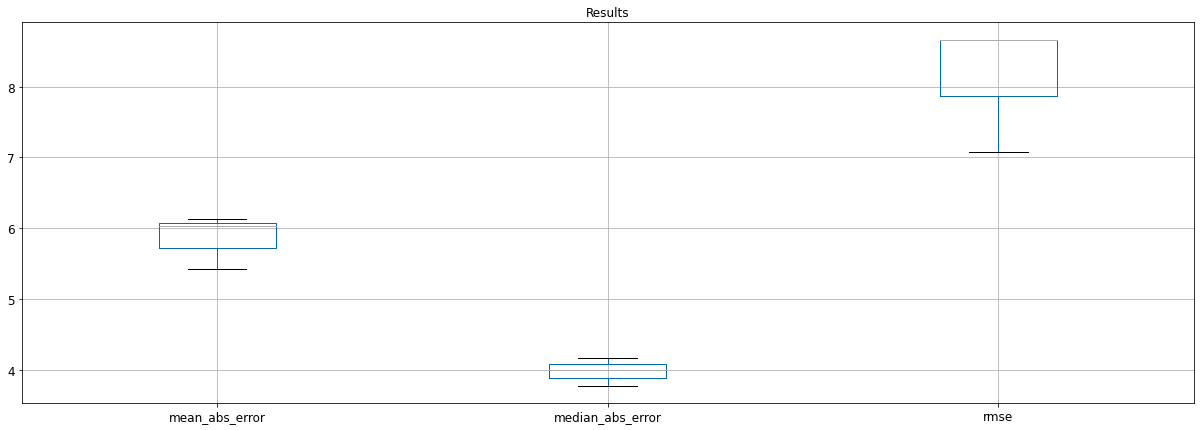

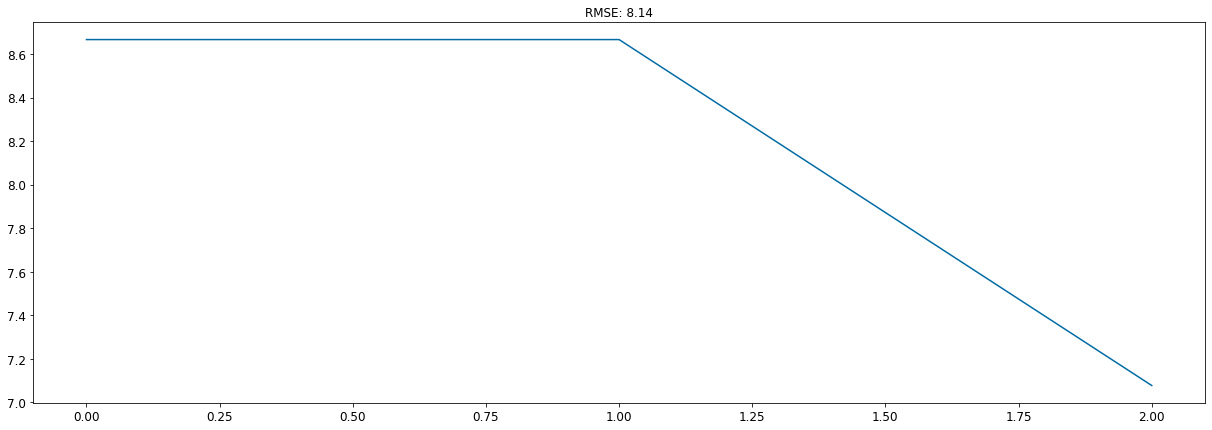

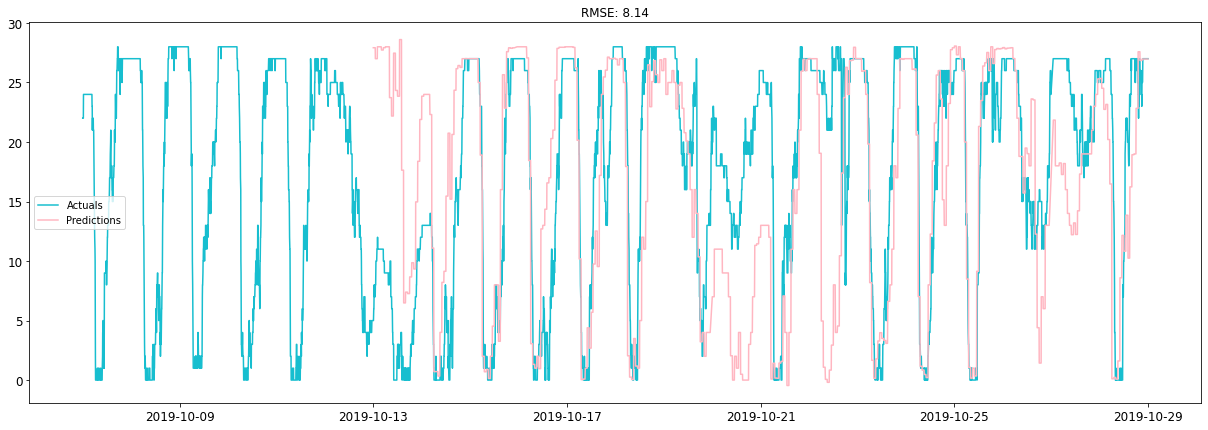

In [16]:
# Generate rolling predictions and results for particle of interest

data = var_station.sort_index().copy()
target = var_interest

fit_func = fit_autoARIMA
predict_func = predict_autoARIMA

min_train_date = '2019-10-07'

week_starts = pd.date_range(min_train_date, data.index.max(), freq='W')

predictions_over_time, results_over_time = [], []

for i, week_start in enumerate(week_starts):
    if i % 10 == 0:
        print(week_start)

    train_set = data.loc[:(week_start - timedelta(hours=1))]
    test_set = data.loc[week_start:(week_start + timedelta(weeks=1, hours=-1))]
    models = train_set.groupby(['weekday', 'hour'])[target].apply(fit_func)
    predictions = test_set.apply(lambda x: predict_func(models.loc[tuple(x[['weekday', 'hour']])], x), axis=1)
    predictions_over_time.append(predictions)    
    results = evaluate_forecast(test_set[target], predictions, 'none')
    results['date'] = week_start
    results_over_time.append(results)  

results_over_time_08 = pd.DataFrame(results_over_time)
predictions_over_time_08 = pd.concat(predictions_over_time)

# Plot results statistics

results_over_time = results_over_time_08

fig, ax = plt.subplots(figsize=(21,7))
results_over_time.drop(['r2_score', 'mse'], axis=1).boxplot()
plt.title('Results')
plt.show()

# Plot RMSE overtime

fig, ax = plt.subplots(figsize=(21,7))
rmse_over_time = plt.plot(results_over_time['rmse'])
error = results_over_time['rmse'].mean()
plt.title('RMSE: %.2f'% error)
plt.show()

# Plot actuals and predictions overtime

plot_actuals_predictions(var_station[var_interest][min_train_date:], predictions_over_time_08, results_over_time_08)

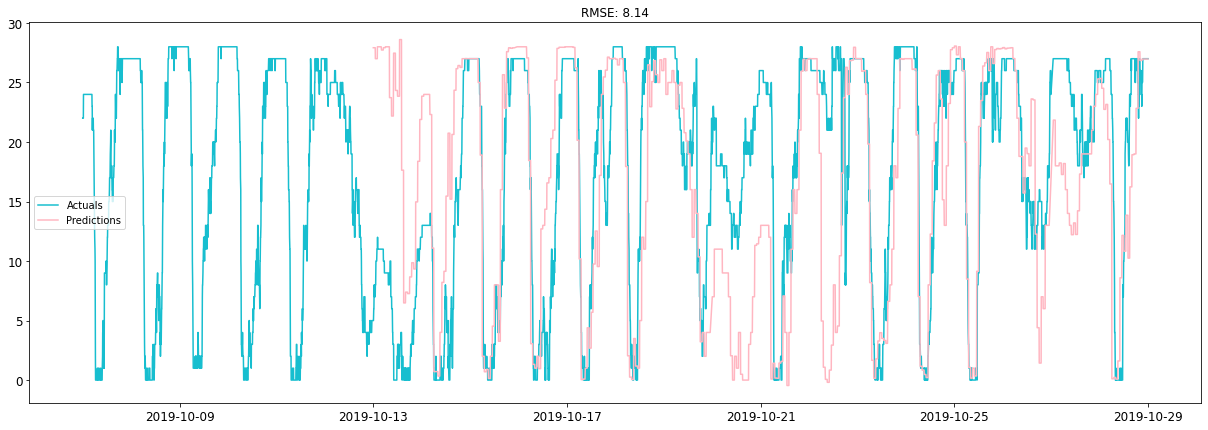

In [17]:
plot_actuals_predictions(var_station[var_interest][min_train_date:], predictions_over_time_08, results_over_time_08)

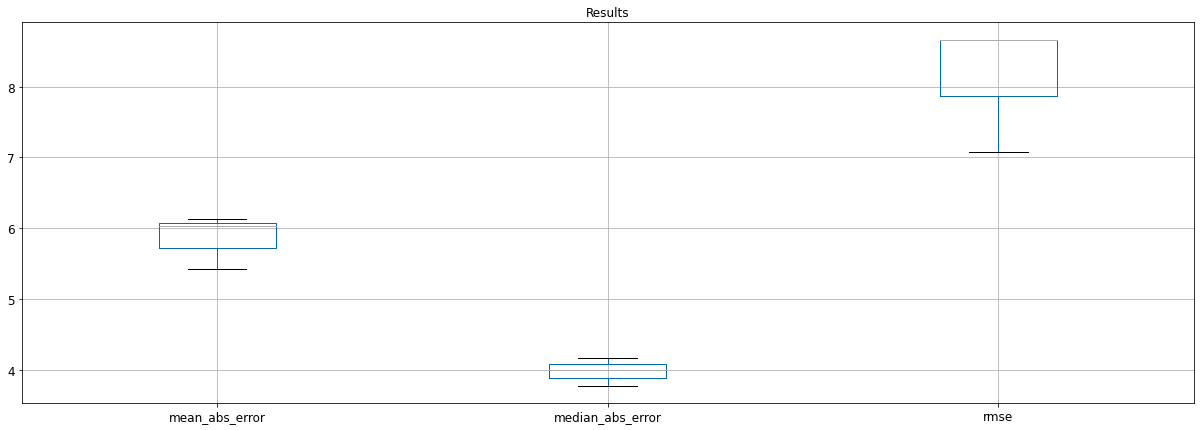

In [18]:
fig, ax = plt.subplots(figsize=(21,7))
results_over_time.drop(['r2_score', 'mse'], axis=1).boxplot()
plt.title('Results')
plt.show()

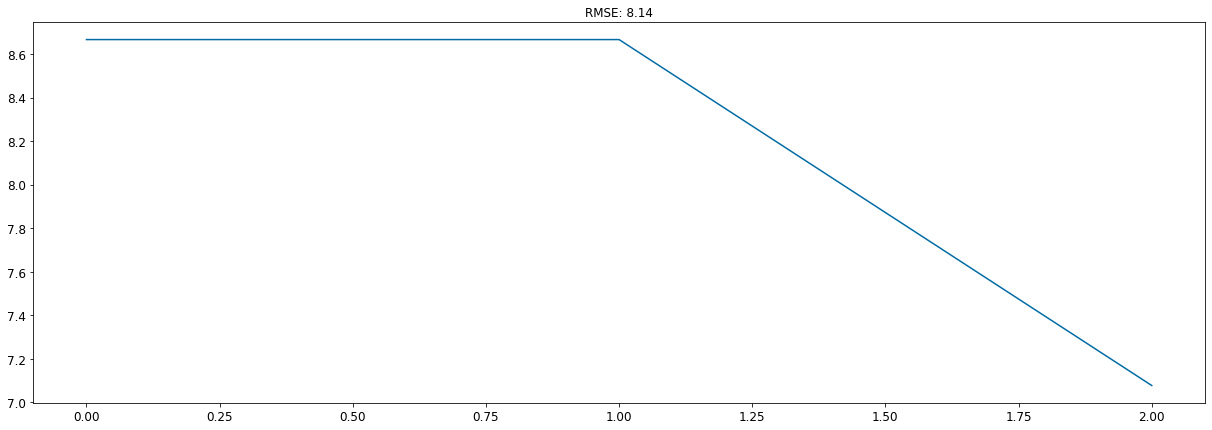

In [19]:
fig, ax = plt.subplots(figsize=(21,7))
rmse_over_time = plt.plot(results_over_time['rmse'])
error = results_over_time['rmse'].mean()
plt.title('RMSE: %.2f'% error)
plt.show()

In [20]:
results_over_time_08

,models,r2_score,mean_abs_error,median_abs_error,mse,rmse,date
0,none,0.297384,6.133803,4.000000,75.107026,8.666431,2019-10-13
1,none,-0.014893,6.025172,3.777778,75.106437,8.666397,2019-10-20
2,none,0.123365,5.422994,4.169756,50.076292,7.076460,2019-10-27


## Prediction: Station 126

In [21]:
# Generate dataframe for one variable and one station of interest

var_interest = 'num_bikes_available'
station_of_interest = 126

var_station = df_select.loc[df_select['station_id'] == station_of_interest]
var_station = var_station.drop(columns = [x for x in data_of_interest if x is not var_interest], axis=1)
var_station.drop('station_id', axis=1, inplace=True)
# var_station.fillna(method='ffill', inplace=True)

var_station['weekday'] = var_station.index.weekday
var_station['year'] = var_station.index.year
var_station['month'] = var_station.index.month
var_station['day'] = var_station.index.day
var_station['hour'] = var_station.index.hour
var_station['minute'] = var_station.index.minute
var_station['second'] = var_station.index.minute
# var_station.fillna(0, inplace=True)

print(f'DF shape: {var_station.shape}')
print(f'Missing values: {var_station[var_interest].isnull().sum()}')
var_station.head()

DF shape: (8040, 8)
Missing values: 0


,num_bikes_available,weekday,year,month,day,hour,minute,second
last_reported_2,,,,,,,,
2019-10-01 00:01:36,17,1,2019,10,1,0,1,1
2019-10-01 00:05:59,17,1,2019,10,1,0,5,5
2019-10-01 00:14:47,17,1,2019,10,1,0,14,14
2019-10-01 00:19:09,17,1,2019,10,1,0,19,19
2019-10-01 00:23:34,17,1,2019,10,1,0,23,23


2019-10-13 00:00:00
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-260.527, BIC=-259.557, Time=0.026 seconds
Total fit time: 0.026 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=25.495, BIC=26.291, Time=0.012 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=26.089, BIC=27.282, Time=0.031 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=23.306, BIC=24.500, Time=0.077 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=26.549, BIC=26.947, Time=0.016 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=25.129, BIC=26.720, Time=0.133 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of th

Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=29.808, BIC=31.748, Time=0.164 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=31.801, BIC=34.226, Time=0.231 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=32.086, BIC=34.511, Time=0.115 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=31.622, BIC=33.562, Time=0.044 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=33.785, BIC=36.694, Time=0.249 seconds
Total fit time: 1.184 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=21.419, BIC=22.389, Time=0.018 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=17.530, BIC=18.984, Time=0.055 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=18.853, BIC=20.308, Time=0.035 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=108.552, BIC=109.037, Time=0.007 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=19.

Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=31.565, BIC=33.020, Time=0.044 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=31.896, BIC=33.350, Time=0.024 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=110.618, BIC=111.103, Time=0.004 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=30.949, BIC=33.373, Time=0.089 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=32.848, BIC=35.273, Time=0.118 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=33.553, BIC=36.947, Time=0.165 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=32.768, BIC=34.708, Time=0.074 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=30.793, BIC=33.702, Time=0.160 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=28.925, BIC=31.349, Time=0.150 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; 

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=109.895, BIC=113.302, Time=0.030 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=108.813, BIC=109.948, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=109.098, BIC=113.640, Time=0.091 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.307 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=91.276, BIC=98.089, Time=0.203 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=88.827, BIC=91.098, Time=0.008 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=89.324, BIC=92.730, Time=0.013 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=88.570, BIC=91.977, Time=0.014 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=86.901, BIC=88.037, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=90.477, 

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=85.873, BIC=89.408, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=85.036, BIC=88.570, Time=0.021 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=82.961, BIC=84.140, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=84.839, BIC=89.552, Time=0.025 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Total fit time: 0.237 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=122.061, BIC=129.130, Time=0.129 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=122.244, BIC=124.600, Time=0.010 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=121.064, BIC=124.599, Time=0.028 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=121.946, BIC=125.480, Time=0.017 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=202.71

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=114.563, BIC=121.376, Time=0.126 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=107.582, BIC=109.853, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=109.551, BIC=112.957, Time=0.018 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=109.554, BIC=112.960, Time=0.016 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=106.389, BIC=107.525, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=111.518, BIC=116.060, Time=0.030 seconds
Total fit time: 0.205 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=40.575, BIC=47.388, Time=0.165 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=33.971, BIC=36.242, Time=0.012 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=35.969, BIC=39.376, Time=0.017 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=35.969, BIC=39.376, Time=0.019 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [interc

Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=87.164, BIC=93.054, Time=0.065 seconds
Total fit time: 0.240 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=135.088, BIC=142.157, Time=0.080 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=141.364, BIC=143.720, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=131.496, BIC=135.030, Time=0.035 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=133.872, BIC=137.406, Time=0.014 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=201.313, BIC=202.491, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=131.974, BIC=136.686, Time=0.034 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=132.514, BIC=137.226, Time=0.046 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=129.005, BIC=134.895, Time=0.113 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close t

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=82.846, BIC=89.914, Time=0.134 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=109.784, BIC=112.140, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=83.248, BIC=86.782, Time=0.033 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=88.320, BIC=91.854, Time=0.047 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=211.342, BIC=212.520, Time=0.004 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=81.666, BIC=87.556, Time=0.111 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=84.930, BIC=89.642, Time=0.043 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=80.517, BIC=85.229, Time=0.046 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=81.006, BIC=86.896, Time=0.100 seconds
Near non-invertible roots for order (2, 0, 1)

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=111.348, BIC=118.416, Time=0.128 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=105.338, BIC=107.695, Time=0.011 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=107.291, BIC=110.825, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=107.286, BIC=110.820, Time=0.015 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=104.360, BIC=105.538, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=107.353, BIC=112.065, Time=0.080 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.258 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=110.168, BIC=116.981, Time=0.165 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=102.527, BIC=104.798, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=62.444, BIC=69.257, Time=0.166 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=57.566, BIC=59.837, Time=0.020 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=59.253, BIC=62.660, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=59.286, BIC=62.692, Time=0.019 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=55.853, BIC=56.989, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=60.760, BIC=65.302, Time=0.041 seconds
Total fit time: 0.271 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=63.295, BIC=70.363, Time=0.151 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=69.975, BIC=72.331, Time=0.018 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=57.828, BIC=61.362, Time=0.040 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=61.552, BIC=65.086, Time=0.017 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; 

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=50.472, BIC=57.285, Time=0.100 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=49.913, BIC=52.184, Time=0.012 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=51.630, BIC=55.037, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=51.545, BIC=54.951, Time=0.018 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=50.306, BIC=51.442, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=53.127, BIC=57.669, Time=0.088 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 0.242 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=141.968, BIC=149.036, Time=0.060 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=166.577, BIC=168.933, Time=0.005 seconds
Fit ARIMA(1,0,0)x

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=78.217, BIC=85.030, Time=0.199 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=72.848, BIC=75.119, Time=0.005 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=74.396, BIC=77.802, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=74.505, BIC=77.911, Time=0.014 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=72.603, BIC=73.738, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=76.031, BIC=80.573, Time=0.029 seconds
Total fit time: 0.270 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=77.388, BIC=84.201, Time=0.140 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=72.623, BIC=74.894, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=74.209, BIC=77.616, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=73.981, BIC=77.388, Time=0.016 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; 

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=64.382, BIC=71.450, Time=0.129 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=67.279, BIC=69.635, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=60.531, BIC=64.066, Time=0.064 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=62.961, BIC=66.496, Time=0.013 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=217.139, BIC=218.317, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=62.457, BIC=67.169, Time=0.099 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=62.490, BIC=67.203, Time=0.088 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=63.600, BIC=69.490, Time=0.103 seconds
Total fit time: 0.519 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=63.457, BIC=70.270, Time=0.107 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=60.673, BIC=62.944, Time=0.020 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True];

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=78.351, BIC=85.163, Time=0.150 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=73.217, BIC=75.488, Time=0.005 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=74.223, BIC=77.630, Time=0.013 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=74.050, BIC=77.457, Time=0.016 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=71.796, BIC=72.931, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=74.431, BIC=78.973, Time=0.083 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.277 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=76.207, BIC=83.020, Time=0.155 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=70.663, BIC=72.934, Time=0.005 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=72.564, BIC=75.

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=89.326, BIC=96.395, Time=0.079 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=92.373, BIC=94.729, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=88.174, BIC=91.708, Time=0.025 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=83.391, BIC=86.926, Time=0.015 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=206.062, BIC=207.240, Time=0.004 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=85.372, BIC=90.085, Time=0.070 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=85.374, BIC=90.086, Time=0.021 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=87.385, BIC=93.276, Time=0.044 seconds
Total fit time: 0.268 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=84.418, BIC=90.964, Time=0.165 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=80.659, BIC=82.841, Time=0.005 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True];

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=28.564, BIC=31.473, Time=0.154 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=26.721, BIC=27.691, Time=0.012 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=23.413, BIC=24.868, Time=0.041 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=24.895, BIC=26.350, Time=0.016 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=104.990, BIC=105.475, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=25.505, BIC=27.444, Time=0.078 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=27.758, BIC=29.697, Time=0.113 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=27.561, BIC=29.985, Time=0.120 seconds
Total fit time: 0.542 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-238.483, BIC=-237.687, Time=0.026 seconds
Total fit time: 0.026 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=14.749, BIC=18.138, Time=0.145 seconds
Fit ARIMA(

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=27.125, BIC=30.035, Time=0.195 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=21.419, BIC=22.389, Time=0.012 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=23.328, BIC=24.783, Time=0.052 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=23.116, BIC=24.571, Time=0.021 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=110.785, BIC=111.270, Time=0.005 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=23.899, BIC=25.839, Time=0.162 seconds
Near non-invertible roots for order (1, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.450 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=43.614, BIC=46.524, Time=0.162 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=20.006, BIC=20.975, Time=0.019 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=21.465, BIC=2

Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Total fit time: 1.210 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=127.053, BIC=133.866, Time=0.147 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=120.943, BIC=123.214, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=122.900, BIC=126.307, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=122.896, BIC=126.302, Time=0.016 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=119.827, BIC=120.963, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=123.070, BIC=127.612, Time=0.099 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.292 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=136.110, BIC=142.923, Time

Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=47.338, BIC=52.214, Time=0.086 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=49.186, BIC=55.281, Time=0.140 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=49.240, BIC=55.335, Time=0.119 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=47.559, BIC=52.434, Time=0.056 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=51.228, BIC=58.542, Time=0.126 seconds
Total fit time: 0.730 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=19.305, BIC=26.373, Time=0.134 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=24.731, BIC=27.087, Time=0.019 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=22.825, BIC=26.359, Time=0.019 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=13.681, BIC=17.215, Time=0.068 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of t

Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=64.609, BIC=70.286, Time=0.127 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=68.012, BIC=75.960, Time=0.170 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=65.919, BIC=73.867, Time=0.194 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=63.937, BIC=70.750, Time=0.171 seconds
Near non-invertible roots for order (1, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA(3,1,3)x(0,0,0,0) [intercept=True]; AIC=67.414, BIC=76.498, Time=0.219 seconds
Near non-invertible roots for order (3, 1, 3)(0, 0, 0, 0); setting score to inf (at le

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=129.698, BIC=136.511, Time=0.118 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=123.573, BIC=125.844, Time=0.009 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=124.968, BIC=128.374, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=124.903, BIC=128.310, Time=0.018 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=123.314, BIC=124.450, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=126.861, BIC=131.403, Time=0.034 seconds
Total fit time: 0.204 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=165.668, BIC=175.000, Time=0.068 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=158.310, BIC=161.421, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=159.838, BIC=164.504, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=159.875, BIC=164.541, Time=0.018 seconds
Fit ARIMA(0,1,0)x(0,0,0,0)

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=136.768, BIC=146.270, Time=0.177 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=170.458, BIC=173.625, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=136.032, BIC=140.783, Time=0.021 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=154.067, BIC=158.817, Time=0.022 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=315.183, BIC=316.767, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=135.925, BIC=142.260, Time=0.032 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=137.900, BIC=145.817, Time=0.053 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=137.913, BIC=145.831, Time=0.051 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=136.145, BIC=142.479, Time=0.055 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=138.600, BIC=148.102, Time=0.143 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inver

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=122.212, BIC=129.280, Time=0.151 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=155.616, BIC=157.973, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=127.705, BIC=131.240, Time=0.018 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=136.392, BIC=139.926, Time=0.026 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=203.677, BIC=204.855, Time=0.004 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=125.354, BIC=131.244, Time=0.034 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=121.376, BIC=127.266, Time=0.108 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=124.274, BIC=132.520, Time=0.160 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to t

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=138.592, BIC=147.924, Time=0.158 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=132.509, BIC=135.619, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=134.467, BIC=139.133, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=134.466, BIC=139.132, Time=0.017 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=133.195, BIC=134.751, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=135.723, BIC=141.944, Time=0.102 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.308 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=178.102, BIC=187.434, Time=0.206 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=176.918, BIC=180.029, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=145.658, BIC=150.408, Time=0.025 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=322.807, BIC=324.391, Time=0.005 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=139.029, BIC=145.363, Time=0.099 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=139.029, BIC=145.363, Time=0.059 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=141.027, BIC=148.945, Time=0.143 seconds
Total fit time: 0.493 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=120.231, BIC=129.732, Time=0.135 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=163.852, BIC=167.020, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=117.778, BIC=122.529, Time=0.024 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=136.142, BIC=140.893, Time=0.023 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=319.406, BIC=320.990, Time=0.005 seconds
Fit ARIMA(2,0,0)x(0,0,0,0

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=165.770, BIC=175.102, Time=0.162 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=171.963, BIC=175.074, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=172.158, BIC=176.824, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=168.877, BIC=173.543, Time=0.016 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=171.242, BIC=172.797, Time=0.006 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=164.308, BIC=172.085, Time=0.102 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=165.769, BIC=173.546, Time=0.130 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=167.

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=176.388, BIC=184.305, Time=0.136 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.265 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=173.050, BIC=182.551, Time=0.089 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=194.088, BIC=197.255, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=167.728, BIC=172.479, Time=0.029 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=179.478, BIC=184.228, Time=0.016 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=310.905, BIC=312.489, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=169.723, BIC=176.057, Time=0.044 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=169.724, BIC=176.058, Time=0.039 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=116.123, BIC=125.455, Time=0.156 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=115.488, BIC=118.599, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=117.188, BIC=121.854, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=116.661, BIC=121.327, Time=0.018 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=113.809, BIC=115.365, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=113.571, BIC=119.792, Time=0.098 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.302 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=126.239, BIC=135.740, Time=0.149 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=154.855, BIC=158.023, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=165.602, BIC=174.934, Time=0.169 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=159.028, BIC=162.138, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=160.983, BIC=165.649, Time=0.017 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=160.980, BIC=165.646, Time=0.016 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=157.855, BIC=159.411, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=161.696, BIC=167.918, Time=0.130 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.348 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=158.069, BIC=167.401, Time=0.197 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=152.314, BIC=155.425, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=105.266, BIC=111.600, Time=0.089 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=105.102, BIC=111.436, Time=0.019 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=104.775, BIC=112.692, Time=0.120 seconds
Total fit time: 0.405 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=100.208, BIC=109.709, Time=0.076 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=128.391, BIC=131.558, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=97.759, BIC=102.509, Time=0.035 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=103.951, BIC=108.702, Time=0.016 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=318.514, BIC=320.098, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=99.507, BIC=105.841, Time=0.065 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=99.091, BIC=105.425, Time=0.089 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [i

Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=224.090, BIC=235.175, Time=0.181 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=231.199, BIC=237.533, Time=0.030 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=234.178, BIC=243.680, Time=0.060 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=222.188, BIC=231.689, Time=0.154 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=225.719, BIC=238.387, Time=0.223 seconds
Total fit time: 1.219 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=176.030, BIC=185.362, Time=0.215 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=169.204, BIC=172.315, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=171.182, BIC=175.848, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=162.596, BIC=170.513, Time=0.138 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=170.644, BIC=181.728, Time=0.161 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=164.061, BIC=175.146, Time=0.178 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=169.462, BIC=178.963, Time=0.049 seconds
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=172.026, BIC=184.694, Time=0.177 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA(2,0,4)x(0,0,0,0) [intercept=True]; AIC=163.893, BIC=176.562, Time=

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=136.763, BIC=146.095, Time=0.121 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=135.980, BIC=139.090, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=137.682, BIC=142.348, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=137.250, BIC=141.916, Time=0.015 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=134.382, BIC=135.937, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=132.928, BIC=139.150, Time=0.091 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.266 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=144.271, BIC=153.603, Time=0.077 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=198.882, BIC=201.992, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=128.575, BIC=133.288, Time=0.098 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.282 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=123.986, BIC=130.799, Time=0.157 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=118.254, BIC=120.525, Time=0.005 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=119.958, BIC=123.365, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=119.964, BIC=123.370, Time=0.016 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=117.245, BIC=118.380, Time=0.011 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=121.954, BIC=126.496, Time=0.035 seconds
Total fit time: 0.241 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=126.211, BIC=132

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=76.290, BIC=83.358, Time=0.112 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=76.233, BIC=78.590, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=72.705, BIC=76.239, Time=0.015 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=71.179, BIC=74.714, Time=0.017 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=215.737, BIC=216.915, Time=0.004 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=72.899, BIC=77.612, Time=38.813 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=72.908, BIC=77.620, Time=0.024 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=74.883, BIC=80.773, Time=0.117 seconds
Total fit time: 39.112 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=59.265, BIC=66.078, Time=0.364 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=57.566, BIC=59.837, Time=0.033 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=75.639, BIC=82.452, Time=0.149 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=70.826, BIC=73.097, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=72.603, BIC=76.010, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=72.543, BIC=75.949, Time=0.014 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=69.189, BIC=70.324, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=74.486, BIC=79.028, Time=0.029 seconds
Total fit time: 0.221 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=143.472, BIC=150.540, Time=0.057 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=159.996, BIC=162.352, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=139.668, BIC=143.202, Time=0.019 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=145.235, BIC=148.769, Time=0.016 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=

Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=216.766, BIC=227.851, Time=0.160 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=212.448, BIC=218.782, Time=0.028 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=215.705, BIC=225.206, Time=0.048 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=210.327, BIC=219.828, Time=0.161 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=212.422, BIC=225.090, Time=0.177 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 1.023 seconds
Performing stepwise search to minimize aic
Fit

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=147.626, BIC=152.292, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=147.586, BIC=152.252, Time=0.023 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=143.862, BIC=145.418, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=149.151, BIC=155.372, Time=0.048 seconds
Total fit time: 0.244 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=111.679, BIC=120.838, Time=0.091 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=112.212, BIC=115.265, Time=0.007 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=112.349, BIC=116.928, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=108.519, BIC=113.099, Time=0.046 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=110.212, BIC=111.739, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=107.752, BIC=113.858, Time=0.133 seconds
Near non-invertible roots

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=94.173, BIC=101.950, Time=0.089 seconds
Total fit time: 0.405 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=96.500, BIC=106.165, Time=0.166 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=107.031, BIC=110.253, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=90.619, BIC=95.452, Time=0.068 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=95.563, BIC=100.396, Time=0.016 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=334.345, BIC=335.956, Time=0.115 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=92.610, BIC=99.054, Time=0.114 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=92.611, BIC=99.055, Time=0.091 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=94.609, BIC=102.663, Time=0.076 seconds
Total fit time: 0.665 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=96.8

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=196.663, BIC=207.890, Time=0.154 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=191.763, BIC=195.506, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=193.717, BIC=199.330, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=193.692, BIC=199.306, Time=0.015 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=190.617, BIC=192.488, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=195.730, BIC=203.215, Time=0.036 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Total fit time: 0.236 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=184.679, BIC=195.780, Time=0.167 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=184.076, BIC=187.777, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=228.866, BIC=236.351, Time=0.051 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=230.866, BIC=240.222, Time=0.053 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=233.678, BIC=241.162, Time=0.033 seconds
Total fit time: 0.457 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=186.167, BIC=197.139, Time=0.192 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=185.683, BIC=189.340, Time=0.007 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=187.668, BIC=193.154, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=187.669, BIC=193.155, Time=0.021 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=184.393, BIC=186.222, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=189.612, BIC=196.927, Time=0.046 seconds
Total fit time: 0.290 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=248.261, BIC=259.233, Time=0.033 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=240.261, BIC=243.918, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=242.261, BIC=247.747, Time=0.013 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=242.261, BIC=247.747, Time=0.015 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=238.261, BIC=240.089, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=244.261, BIC=251.575, Time=0.014 seconds
Total fit time: 0.093 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=26.059, BIC=37.410, Time=0.080 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=93.985, BIC=97.769, Time=0.014 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=21.668, BIC=27.344, Time=0.031 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=59.762, BIC=65.438, Time=0.028 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [interc

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=164.498, BIC=175.725, Time=0.171 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=163.317, BIC=167.059, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=165.314, BIC=170.927, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=165.313, BIC=170.926, Time=0.015 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=161.522, BIC=163.394, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=167.298, BIC=174.783, Time=0.046 seconds
Total fit time: 0.263 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=175.941, BIC=187.042, Time=0.172 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=171.753, BIC=175.454, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=173.011, BIC=178.562, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=172.761, BIC=178.312, Time=0.015 seconds
Fit ARIMA(0,1,0)x(0,0,0,0)

Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=243.187, BIC=250.588, Time=0.031 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=243.337, BIC=250.738, Time=0.029 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=245.184, BIC=254.435, Time=0.038 seconds
Total fit time: 0.208 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=236.710, BIC=248.061, Time=0.166 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=299.111, BIC=302.895, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=238.760, BIC=244.435, Time=0.017 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=266.867, BIC=272.542, Time=0.020 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=339.810, BIC=341.702, Time=0.004 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=242.222, BIC=251.682, Time=0.029 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=235.476, BIC=244.935, Time=0.118 seconds
Near non-invertible roots 

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=236.301, BIC=245.657, Time=0.137 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.326 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=230.171, BIC=241.399, Time=0.097 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=270.581, BIC=274.323, Time=0.008 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=225.714, BIC=231.328, Time=0.019 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=241.499, BIC=247.113, Time=0.017 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=333.497, BIC=335.368, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=226.168, BIC=233.653, Time=0.026 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=226.200, BIC=233.685, Time=0.027 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=163.932, BIC=175.283, Time=0.079 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=229.472, BIC=233.256, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=162.940, BIC=168.616, Time=0.025 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=199.589, BIC=205.264, Time=0.018 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=427.346, BIC=429.238, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=164.385, BIC=171.952, Time=0.037 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=164.590, BIC=172.157, Time=0.034 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=165.473, BIC=174.932, Time=0.095 seconds
Total fit time: 0.301 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=178.561, BIC=189.788, Time=0.055 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=222.393, BIC=226.136, Ti

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=238.790, BIC=249.891, Time=0.164 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=233.003, BIC=236.704, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=234.977, BIC=240.527, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=234.975, BIC=240.525, Time=0.014 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=232.103, BIC=233.953, Time=0.008 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=235.026, BIC=242.426, Time=0.123 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.335 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=258.818, BIC=270.045, Time=0.171 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=341.699, BIC=345.441, Time=0.005 seconds
Fit A

Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=129.872, BIC=137.273, Time=0.073 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=131.046, BIC=140.296, Time=0.122 seconds
Total fit time: 0.484 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=138.891, BIC=150.118, Time=0.173 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=174.141, BIC=177.883, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=133.389, BIC=139.003, Time=0.043 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=149.204, BIC=154.818, Time=0.017 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=429.855, BIC=431.727, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=135.368, BIC=142.853, Time=0.023 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=135.358, BIC=142.843, Time=0.058 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=137.250, BIC=146.606, Time=0.134 seconds
Total fit time: 0.462 seco

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=177.762, BIC=187.118, Time=0.128 seconds
Total fit time: 0.481 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=154.364, BIC=165.465, Time=0.199 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=197.759, BIC=201.459, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=149.336, BIC=154.887, Time=0.038 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=170.040, BIC=175.590, Time=0.017 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=423.262, BIC=425.112, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=150.867, BIC=158.268, Time=0.048 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=150.961, BIC=158.362, Time=0.044 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=152.459, BIC=161.710, Time=0.151 seconds
Total fit time: 0.510 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=216.302, BIC=225.761, Time=0.129 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=220.123, BIC=233.366, Time=0.203 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=218.693, BIC=231.936, Time=0.188 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=221.170, BIC=228.737, Time=0.037 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=224.555, BIC=235.906, Time=0.046 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=217.606, BIC=228.957, Time=0.167 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit c

Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=210.338, BIC=223.437, Time=0.176 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=217.788, BIC=230.886, Time=0.152 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=214.806, BIC=222.291, Time=0.026 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=217.406, BIC=228.633, Time=0.058 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=208.309, BIC=219.536, Time=0.160 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=210.733, BIC=225.703, Time=0.225 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit c

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=184.326, BIC=193.682, Time=0.131 seconds
Total fit time: 0.438 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=157.423, BIC=168.651, Time=0.111 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=194.368, BIC=198.110, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=155.273, BIC=160.887, Time=0.031 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=175.819, BIC=181.433, Time=0.018 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=432.236, BIC=434.107, Time=0.005 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=155.580, BIC=163.064, Time=0.052 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=156.200, BIC=163.684, Time=0.038 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=155.738, BIC=165.094, Time=0.089 seconds
Total fit time: 0.353 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]

Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=190.545, BIC=200.046, Time=0.162 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=192.846, BIC=200.764, Time=0.036 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=192.799, BIC=200.716, Time=0.028 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=192.224, BIC=203.308, Time=0.188 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 0.776 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=189.113, BIC=198.614, Time=0.155 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=239.102, BIC=242.269, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=187.112, BIC=191.863, 

Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=116.064, BIC=123.841, Time=0.101 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=119.380, BIC=130.267, Time=0.172 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=117.229, BIC=128.117, Time=0.179 seconds
Near non-invertible roots for order (2, 1, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=114.533, BIC=120.754, Time=0.031 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=114.386, BIC=120.607, Time=0.074 seconds
Near non-invertible roots for order (0, 1, 2)(0, 0, 0, 0); setting score to 

Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=138.687, BIC=143.437, Time=0.021 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=161.494, BIC=166.245, Time=0.019 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=321.800, BIC=323.384, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=139.778, BIC=146.112, Time=0.034 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=139.718, BIC=146.052, Time=0.053 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=141.707, BIC=149.624, Time=0.061 seconds
Total fit time: 0.257 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=137.456, BIC=146.957, Time=0.143 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=178.800, BIC=181.967, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=132.518, BIC=137.269, Time=0.023 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=152.172, BIC=156.922, Time=0.014 seconds
Fit ARIMA(0,0,0)x(0,0,0,0)

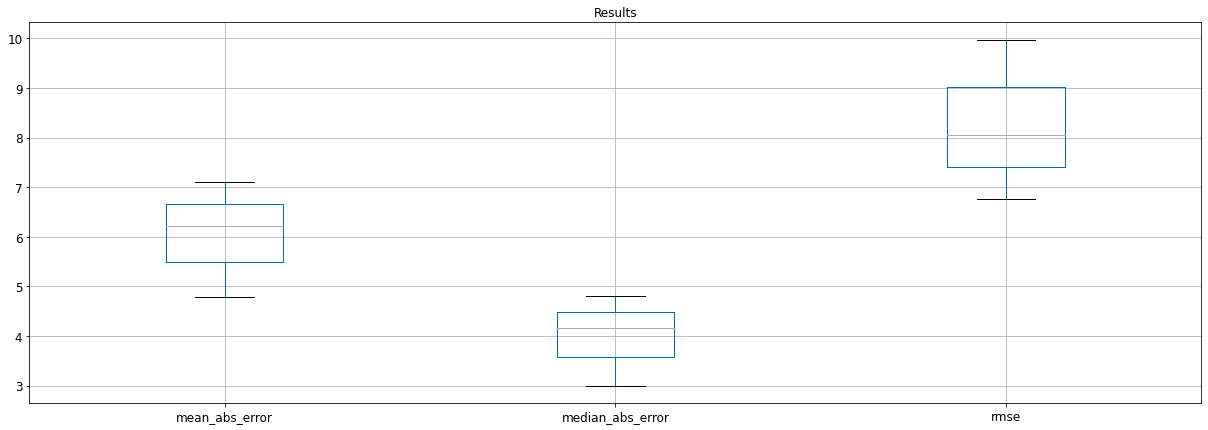

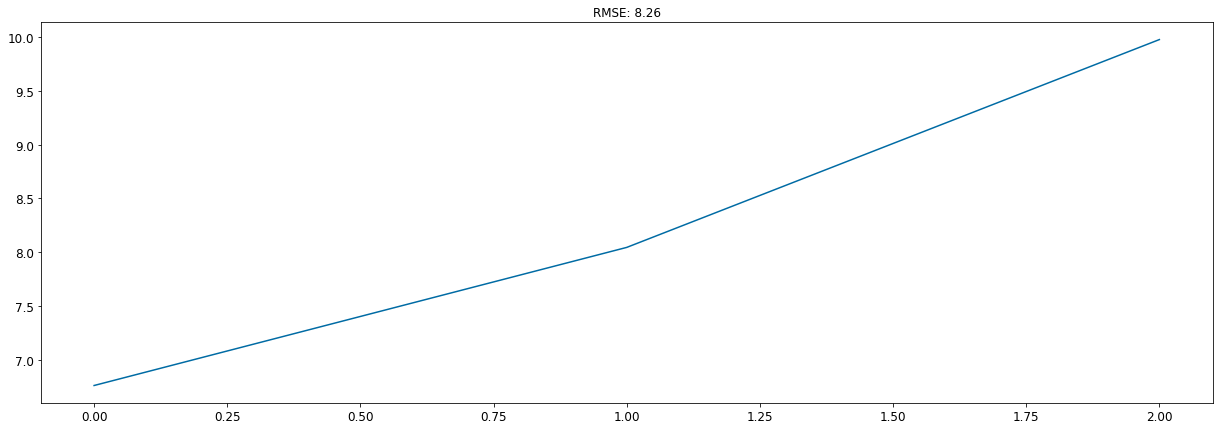

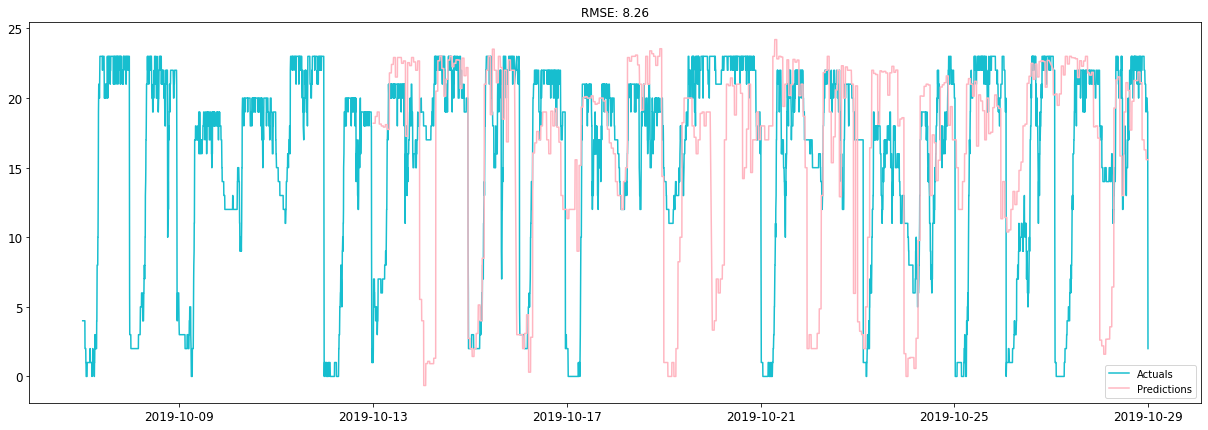

In [22]:
# Generate rolling predictions and results for particle of interest

data = var_station.sort_index().copy()
target = var_interest

fit_func = fit_autoARIMA
predict_func = predict_autoARIMA

min_train_date = '2019-10-07'

week_starts = pd.date_range(min_train_date, data.index.max(), freq='W')

predictions_over_time, results_over_time = [], []

for i, week_start in enumerate(week_starts):
    if i % 10 == 0:
        print(week_start)

    train_set = data.loc[:(week_start - timedelta(hours=1))]
    test_set = data.loc[week_start:(week_start + timedelta(weeks=1, hours=-1))]
    models = train_set.groupby(['weekday', 'hour'])[target].apply(fit_func)
    predictions = test_set.apply(lambda x: predict_func(models.loc[tuple(x[['weekday', 'hour']])], x), axis=1)
    predictions_over_time.append(predictions)    
    results = evaluate_forecast(test_set[target], predictions, 'none')
    results['date'] = week_start
    results_over_time.append(results)  

results_over_time_08 = pd.DataFrame(results_over_time)
predictions_over_time_08 = pd.concat(predictions_over_time)

# Plot results statistics

results_over_time = results_over_time_08

fig, ax = plt.subplots(figsize=(21,7))
results_over_time.drop(['r2_score', 'mse'], axis=1).boxplot()
plt.title('Results')
plt.show()

# Plot RMSE overtime

fig, ax = plt.subplots(figsize=(21,7))
rmse_over_time = plt.plot(results_over_time['rmse'])
error = results_over_time['rmse'].mean()
plt.title('RMSE: %.2f'% error)
plt.show()

# Plot actuals and predictions overtime

plot_actuals_predictions(var_station[var_interest][min_train_date:], predictions_over_time_08, results_over_time_08)

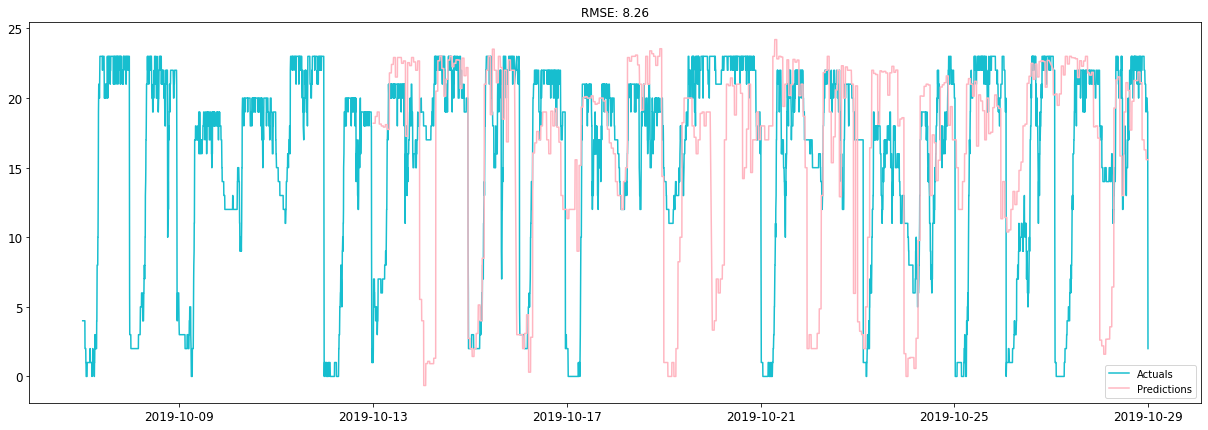

In [23]:
plot_actuals_predictions(var_station[var_interest][min_train_date:], predictions_over_time_08, results_over_time_08)

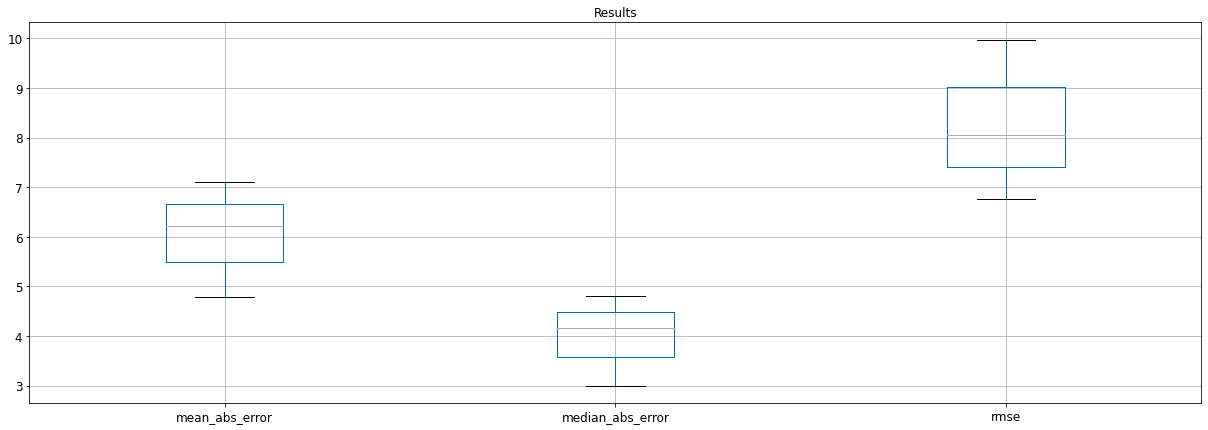

In [24]:
fig, ax = plt.subplots(figsize=(21,7))
results_over_time.drop(['r2_score', 'mse'], axis=1).boxplot()
plt.title('Results')
plt.show()

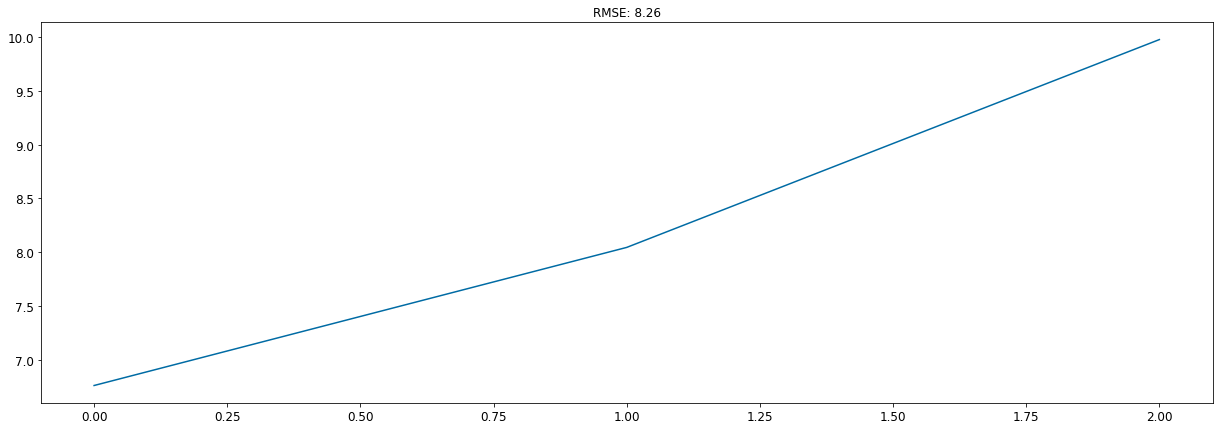

In [25]:
fig, ax = plt.subplots(figsize=(21,7))
rmse_over_time = plt.plot(results_over_time['rmse'])
error = results_over_time['rmse'].mean()
plt.title('RMSE: %.2f'% error)
plt.show()

In [26]:
results_over_time_08

,models,r2_score,mean_abs_error,median_abs_error,mse,rmse,date
0,none,-0.028148,4.781790,3.000000,45.741243,6.763227,2019-10-13
1,none,-0.272079,6.206733,4.803792,64.732489,8.045650,2019-10-20
2,none,-0.788453,7.105558,4.162209,99.511157,9.975528,2019-10-27


## Prediction: Station 102

In [27]:
# Generate dataframe for one variable and one station of interest

var_interest = 'num_bikes_available'
station_of_interest = 102

var_station = df_select.loc[df_select['station_id'] == station_of_interest]
var_station = var_station.drop(columns = [x for x in data_of_interest if x is not var_interest], axis=1)
var_station.drop('station_id', axis=1, inplace=True)
# var_station.fillna(method='ffill', inplace=True)

var_station['weekday'] = var_station.index.weekday
var_station['year'] = var_station.index.year
var_station['month'] = var_station.index.month
var_station['day'] = var_station.index.day
var_station['hour'] = var_station.index.hour
var_station['minute'] = var_station.index.minute
var_station['second'] = var_station.index.minute
# var_station.fillna(0, inplace=True)

print(f'DF shape: {var_station.shape}')
print(f'Missing values: {var_station[var_interest].isnull().sum()}')
var_station.head()

DF shape: (8040, 8)
Missing values: 0


,num_bikes_available,weekday,year,month,day,hour,minute,second
last_reported_2,,,,,,,,
2019-10-01 00:02:36,0,1,2019,10,1,0,2,2
2019-10-01 00:07:11,0,1,2019,10,1,0,7,7
2019-10-01 00:11:31,0,1,2019,10,1,0,11,11
2019-10-01 00:15:47,0,1,2019,10,1,0,15,15
2019-10-01 00:24:55,0,1,2019,10,1,0,24,24


2019-10-13 00:00:00
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-260.527, BIC=-259.557, Time=0.023 seconds
Total fit time: 0.024 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-260.527, BIC=-259.557, Time=0.037 seconds
Total fit time: 0.037 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-260.527, BIC=-259.557, Time=0.025 seconds
Total fit time: 0.025 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=13.771, BIC=16.680, Time=0.187 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=21.081, BIC=22.051, Time=0.014 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=11.224, BIC=12.678, Time=0.019 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=16.263, BIC=17.718, Time=0.018 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=25.549, BIC=26.034, Time=0.008 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=13.092, BIC=15.032, Time=0.029 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True

Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=30.985, BIC=32.178, Time=0.027 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=81.444, BIC=81.842, Time=0.007 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=31.699, BIC=33.290, Time=0.058 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=31.774, BIC=33.365, Time=0.041 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=33.006, BIC=34.995, Time=0.110 seconds
Total fit time: 0.450 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=36.876, BIC=40.265, Time=0.108 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=39.852, BIC=40.982, Time=0.013 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=35.046, BIC=36.741, Time=0.020 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=33.476, BIC=35.171, Time=0.051 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of 

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=38.670, BIC=45.739, Time=0.178 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=42.394, BIC=44.750, Time=0.011 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=38.852, BIC=42.386, Time=0.020 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=36.836, BIC=40.370, Time=0.026 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=74.651, BIC=75.829, Time=0.004 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=38.622, BIC=43.335, Time=0.029 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=38.258, BIC=42.970, Time=0.021 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=40.096, BIC=45.986, Time=0.038 seconds
Total fit time: 0.330 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=16.120, BIC=22.933, Time=0.149 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.005, BIC=13.276, Time=0.012 seconds
Fit

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=37.544, BIC=44.357, Time=0.279 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=44.982, BIC=47.253, Time=0.012 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=45.348, BIC=48.755, Time=0.017 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=37.122, BIC=40.528, Time=0.096 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=42.982, BIC=44.117, Time=0.008 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=40.330, BIC=46.007, Time=0.200 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=38.953, BIC=44.631, Time=0.135 seconds
Near non-invertible root

Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=102.289, BIC=109.357, Time=0.057 seconds
Total fit time: 0.338 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=15.989, BIC=22.802, Time=0.168 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.005, BIC=13.276, Time=0.012 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=12.784, BIC=16.191, Time=0.028 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.751, BIC=16.158, Time=0.022 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=11.097, BIC=12.233, Time=0.010 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.671, BIC=19.213, Time=0.052 seconds
Total fit time: 0.295 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-525.054, BIC=-522.698, Time=0.029 seconds
Total fit time: 0.029 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-525.054, BIC=-522.698, Time=0.033 seconds
Total fit time: 0.033 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [interc

Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=48.084, BIC=53.975, Time=0.105 seconds
Total fit time: 0.393 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=83.818, BIC=90.887, Time=0.132 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=98.462, BIC=100.818, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=80.952, BIC=84.486, Time=0.016 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=87.058, BIC=90.592, Time=0.016 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=132.200, BIC=133.378, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=82.940, BIC=87.653, Time=0.031 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=82.942, BIC=87.655, Time=0.028 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=84.927, BIC=90.817, Time=0.058 seconds
Total fit time: 0.295 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=74.164, B

Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=83.225, BIC=90.294, Time=0.091 seconds
Total fit time: 0.368 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=129.867, BIC=136.935, Time=0.113 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=146.048, BIC=148.405, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=126.217, BIC=129.751, Time=0.013 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=134.496, BIC=138.030, Time=0.017 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=151.771, BIC=152.949, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=128.001, BIC=132.713, Time=0.018 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=128.048, BIC=132.761, Time=0.032 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=127.956, BIC=133.847, Time=0.116 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close t

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=1.888, BIC=8.957, Time=0.135 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-5.186, BIC=-2.830, Time=0.018 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-3.233, BIC=0.301, Time=0.029 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=-3.238, BIC=0.296, Time=0.020 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=-6.164, BIC=-4.986, Time=0.012 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-2.107, BIC=2.606, Time=0.129 seconds
Near non-invertible roots for order (1, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Total fit time: 0.349 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-525.054, BIC=-522.698, Time=0.028 seconds
Total fit time: 0.029 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-525.054, BIC=-522.698, Time=0.037 seconds
Total fit time: 0.037 seconds
F

Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=89.211, BIC=97.457, Time=0.238 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=92.558, BIC=100.804, Time=0.213 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=90.351, BIC=95.063, Time=0.049 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=92.298, BIC=99.366, Time=0.124 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=91.336, BIC=98.404, Time=0.204 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=88.420, BIC=97.845, Time=0.284 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 1.961 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=99.246, BIC=106.315, Time=0.108 s

Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=99.184, BIC=105.278, Time=0.048 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=107.520, BIC=112.395, Time=0.058 seconds
Near non-invertible roots for order (0, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=102.053, BIC=106.928, Time=0.029 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=101.087, BIC=108.400, Time=0.047 seconds
Fit ARIMA(0,0,3)x(0,0,0,0) [intercept=True]; AIC=106.042, BIC=112.137, Time=0.047 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=99.025, BIC=105.119, Time=0.097 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=97.341, BIC=102.217, Time=0.027 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=98.922, BIC=105.017, Time=0.042 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=99.351, BIC=106.665, Time=0.057 seconds
Total fit time: 0.561 seconds
Perform

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=111.524, BIC=118.337, Time=0.261 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=107.957, BIC=110.228, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=109.928, BIC=113.334, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=109.918, BIC=113.324, Time=0.013 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=106.752, BIC=107.887, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=111.770, BIC=116.312, Time=0.030 seconds
Total fit time: 0.333 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=112.142, BIC=118.955, Time=0.131 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=104.788, BIC=107.059, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=106.771, BIC=110.178, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=106.773, BIC=110.179, Time=0.016 seconds
Fit ARIMA(0,1,0)x(0,0,0,0)

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=105.948, BIC=112.761, Time=0.134 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=99.300, BIC=101.571, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=101.300, BIC=104.707, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=101.300, BIC=104.707, Time=0.014 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=100.135, BIC=101.270, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=103.164, BIC=107.706, Time=0.066 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.245 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=91.000, BIC=97.813, Time=0.194 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=86.768, BIC=89.039, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=88.6

Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=16.065, BIC=24.312, Time=0.194 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=11.731, BIC=19.977, Time=0.191 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=14.963, BIC=19.676, Time=0.045 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=18.662, BIC=25.731, Time=0.105 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=13.902, BIC=20.970, Time=0.159 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=20.294, BIC=29.719, Time=0.189 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=18.410, BIC=24.300, Time=0.119 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 0.315 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=64.849, BIC=71.917, Time=0.181 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=86.995, BIC=89.351, Time=0.009 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=66.993, BIC=70.527, Time=0.013 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=74.590, BIC=78.124, Time=0.016 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=97.455, BIC=98.634, Time=0.004 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=70.533, BIC=76.424, Time=0.031 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=66.622, BIC=72.512, Time=0.112 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setti

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=13.182, BIC=15.606, Time=0.123 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 0.428 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-260.527, BIC=-259.557, Time=0.026 seconds
Total fit time: 0.026 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=25.881, BIC=28.791, Time=0.145 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=30.227, BIC=31.196, Time=0.012 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=23.184, BIC=24.639, Time=0.017 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=25.215, BIC=26.669, Time=0.016 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=37.015, BIC=37.500, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=24.591, BIC=26.531, Time=0.020 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [in

Fit ARIMA(4,0,1)x(0,0,0,0) [intercept=True]; AIC=6.041, BIC=9.435, Time=0.200 seconds
Fit ARIMA(4,0,0)x(0,0,0,0) [intercept=True]; AIC=6.440, BIC=9.349, Time=0.144 seconds
Fit ARIMA(4,0,2)x(0,0,0,0) [intercept=True]; AIC=4.368, BIC=8.248, Time=0.223 seconds
Fit ARIMA(4,0,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Total fit time: 2.277 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=39.085, BIC=39.881, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=41.059, BIC=42.252, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=41.018, BIC=42.212, Time=0.015 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=41.330, BIC=41.728, Time=0.013 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=41.560, BIC=43.152, Time=0.

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=75.866, BIC=81.756, Time=0.208 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=76.109, BIC=84.355, Time=0.305 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=75.598, BIC=83.844, Time=0.170 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=77.214, BIC=81.926, Time=0.091 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=78.583, BIC=85.652, Time=0.188 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=77.443, BIC=84.511, Time=0.208 seconds
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=77.388, BIC=86.813, Time=0.212 seconds
Total fit time: 1.881 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=47.276, BIC=53.823, Time=0.227 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=45.746, BIC=47.9

Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-547.098, BIC=-544.661, Time=0.025 seconds
Total fit time: 0.025 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-525.054, BIC=-522.698, Time=0.022 seconds
Total fit time: 0.022 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-789.582, BIC=-786.415, Time=0.025 seconds
Total fit time: 0.025 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-789.582, BIC=-786.415, Time=0.025 seconds
Total fit time: 0.025 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-789.582, BIC=-786.415, Time=0.027 seconds
Total fit time: 0.027 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=46.766, BIC=56.267, Time=0.156 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=55.243, BIC=58.410, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=48.914, BIC=53.665, Time=0.021 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=45.042, BIC=49.793, Time=0.024 sec

Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=103.861, BIC=113.362, Time=0.071 seconds
Total fit time: 0.357 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=6.873, BIC=16.205, Time=0.137 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=1.089, BIC=4.200, Time=0.019 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=2.956, BIC=7.622, Time=0.016 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=2.935, BIC=7.601, Time=0.037 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=1.149, BIC=2.704, Time=0.010 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=3.081, BIC=9.302, Time=0.105 seconds
Near non-invertible roots for order (1, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.327 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=176.878, BIC=186.544, Time=0.145 second

Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-789.582, BIC=-786.415, Time=0.027 seconds
Total fit time: 0.028 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-789.582, BIC=-786.415, Time=0.026 seconds
Total fit time: 0.026 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=-15.860, BIC=-6.359, Time=0.060 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=-23.857, BIC=-20.690, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-21.858, BIC=-17.107, Time=0.041 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=-21.858, BIC=-17.108, Time=0.039 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=-24.843, BIC=-23.260, Time=0.010 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=-19.858, BIC=-13.524, Time=0.032 seconds
Total fit time: 0.201 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=7.342, BIC=16.843, Time=0.180 seconds
Fit ARIMA(0,0

Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=92.348, BIC=105.016, Time=0.182 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 1.171 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=101.053, BIC=110.385, Time=0.092 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=94.940, BIC=98.050, Time=0.015 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=96.435, BIC=101.101, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=96.208, BIC=100.874, Time=0.016 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=93.516, BIC=95.071, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=96.322, BIC=102.543, Time=0.081 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit cir

Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=-15.216, BIC=-7.439, Time=0.132 seconds
Near non-invertible roots for order (1, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=-13.596, BIC=-5.819, Time=0.102 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=-11.344, BIC=-0.457, Time=0.171 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=-11.650, BIC=-0.763, Time=0.195 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,

Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=38.197, BIC=49.281, Time=0.198 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=31.803, BIC=42.888, Time=0.208 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=33.471, BIC=39.805, Time=0.052 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=37.155, BIC=46.656, Time=0.059 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=35.815, BIC=45.316, Time=0.107 seconds
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=33.848, BIC=46.516, Time=0.226 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 1.169 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=31.259, BIC=40.591, Time=0.150 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=27.409, BIC=30.520, Time=0.012 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=29.409, BIC=34.0

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=9.511, BIC=19.177, Time=0.158 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=12.918, BIC=16.139, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=12.132, BIC=16.964, Time=0.017 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=11.506, BIC=16.339, Time=0.025 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=14.046, BIC=15.657, Time=0.009 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=15.475, BIC=23.530, Time=0.238 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=14.972, BIC=23.027, Time=0.044 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=11.332, BIC=22.608, Time=0.172 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=11.329, BIC=22.605, Time=0.158 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=183.174, BIC=192.675, Time=0.132 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=231.403, BIC=234.570, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=182.447, BIC=187.198, Time=0.014 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=206.600, BIC=211.351, Time=0.019 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=242.211, BIC=243.795, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=183.925, BIC=190.259, Time=0.019 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=184.034, BIC=190.368, Time=0.035 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=181.372, BIC=189.290, Time=0.120 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.353 seconds
Performing stepwise search to minimize aic
Fit A

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=154.521, BIC=160.742, Time=0.097 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.244 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=164.680, BIC=174.181, Time=0.050 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=222.294, BIC=225.461, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=159.463, BIC=164.213, Time=0.015 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=192.571, BIC=197.322, Time=0.019 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=266.719, BIC=268.302, Time=0.005 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=160.550, BIC=166.884, Time=0.022 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=160.712, BIC=167.046, Time=0.024 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=199.090, BIC=208.591, Time=0.093 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=232.249, BIC=235.416, Time=0.009 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=195.482, BIC=200.233, Time=0.014 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=208.954, BIC=213.705, Time=0.020 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=238.047, BIC=239.630, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=196.597, BIC=202.931, Time=0.142 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=196.783, BIC=203.117, Time=0.026 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=196.325, BIC=204.243, Time=0.100 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.412 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=114.239, BIC=123.571, Time=0.229 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=107.597, BIC=110.708, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=109.589, BIC=114.255, Time=0.013 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=109.589, BIC=114.255, Time=0.018 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=105.999, BIC=107.555, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=110.379, BIC=116.601, Time=0.109 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.385 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=95.910, BIC=105.069, Time=0.168 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=89.953, BIC=93.006, Time=0.009 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=91

Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=117.103, BIC=121.853, Time=0.063 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=166.960, BIC=168.544, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=107.032, BIC=113.366, Time=0.025 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=107.077, BIC=113.411, Time=0.024 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=106.013, BIC=113.930, Time=0.106 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.379 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=52.512, BIC=61.844, Time=0.202 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=51.165, BIC=54.276, Tim

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=5.973, BIC=13.042, Time=0.141 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=18.998, BIC=21.354, Time=0.144 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=9.958, BIC=13.493, Time=0.016 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=12.662, BIC=16.196, Time=0.018 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=20.202, BIC=21.381, Time=0.009 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=4.007, BIC=9.897, Time=0.131 seconds
Near non-invertible roots for order (1, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=9.756, BIC=15.646, Time=0.118 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=7.801, BIC=16.047, Time

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=3.891, BIC=9.781, Time=0.118 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=7.885, BIC=16.131, Time=0.156 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=7.897, BIC=16.143, Time=0.185 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=1.898, BIC=6.610, Time=0.089 seconds
Near non-invertible roots for order (1, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,3)x(0,0,

Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=33.392, BIC=39.726, Time=0.031 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=35.205, BIC=43.123, Time=0.062 seconds
Total fit time: 0.271 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=41.172, BIC=50.673, Time=0.074 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=54.434, BIC=57.601, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=37.711, BIC=42.462, Time=0.018 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=41.349, BIC=46.100, Time=0.020 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=86.434, BIC=88.018, Time=0.009 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=38.019, BIC=44.353, Time=0.029 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=38.498, BIC=44.832, Time=0.031 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=39.921, BIC=47.838, Time=0.092 seconds
Near non-invertible roots for order (2, 0, 1)(

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=152.403, BIC=161.561, Time=0.145 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=155.332, BIC=158.385, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=156.191, BIC=160.770, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=153.162, BIC=157.741, Time=0.016 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=153.803, BIC=155.330, Time=0.006 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=150.538, BIC=158.170, Time=0.119 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=153.433, BIC=161.065, Time=0.071 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=154.362, BIC=165.046, Time=0.170 seconds
Near non-invertible roots for order (3, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to t

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=32.380, BIC=41.736, Time=0.131 seconds
Total fit time: 0.430 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=157.055, BIC=168.282, Time=0.107 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=169.754, BIC=173.496, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=151.938, BIC=157.551, Time=0.015 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=154.036, BIC=159.650, Time=0.017 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=225.049, BIC=226.920, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=153.206, BIC=160.691, Time=0.025 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=153.082, BIC=160.567, Time=0.041 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=151.726, BIC=161.082, Time=0.139 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=157.046, BIC=168.273, Time=0.059 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [

Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=234.650, BIC=247.893, Time=0.194 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=234.358, BIC=247.601, Time=0.173 seconds
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=234.366, BIC=241.934, Time=0.023 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=236.485, BIC=247.836, Time=0.058 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=232.530, BIC=243.881, Time=0.164 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(3,0,3)x(0,0,0,0) [intercept=True]; AIC=236.225, BIC=251.359, Time=0.186 seconds
Near non-invertible roots for order (3, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit c

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=-34.012, BIC=-22.784, Time=0.155 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=4.036, BIC=7.778, Time=0.018 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=-19.152, BIC=-13.539, Time=0.028 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=-12.087, BIC=-6.473, Time=0.034 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=5.134, BIC=7.005, Time=0.011 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=-35.993, BIC=-26.637, Time=0.102 seconds
Near non-invertible roots for order (1, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=-18.503, BIC=-9.147, Time=0.096 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=-32.057, BIC=-18.959, Time=0.182 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at leas

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=153.271, BIC=164.498, Time=0.167 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=194.482, BIC=198.225, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=152.786, BIC=158.400, Time=0.019 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=171.529, BIC=177.143, Time=0.023 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=303.881, BIC=305.752, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=153.957, BIC=161.442, Time=0.044 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=153.959, BIC=161.444, Time=0.030 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=155.942, BIC=165.298, Time=0.040 seconds
Total fit time: 0.337 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=173.107, BIC=184.335, Time=0.070 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=204.407, BIC=208.149, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0)

Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=230.454, BIC=239.810, Time=0.119 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=235.805, BIC=243.290, Time=0.022 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=232.362, BIC=243.589, Time=0.158 seconds
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.470 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=151.306, BIC=162.533, Time=0.144 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=203.923, BIC=207.665, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=149.327, BIC=154.941, Time=0.015 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=175.290, BIC=180.903, 

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=45.687, BIC=56.914, Time=0.170 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=57.006, BIC=60.748, Time=0.015 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=40.448, BIC=46.062, Time=0.019 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=42.708, BIC=48.322, Time=0.031 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=125.725, BIC=127.596, Time=0.009 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=41.967, BIC=49.452, Time=0.026 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=41.968, BIC=49.452, Time=0.033 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=43.054, BIC=52.410, Time=0.146 seconds
Total fit time: 0.452 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=31.608, BIC=42.709, Time=0.154 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=31.866, BIC=35.567, Time=0.013 seconds
F

Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=168.519, BIC=174.132, Time=0.032 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=187.985, BIC=193.598, Time=0.021 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=316.882, BIC=318.754, Time=0.005 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=169.885, BIC=177.370, Time=0.034 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=170.032, BIC=177.517, Time=0.036 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=170.977, BIC=180.333, Time=0.062 seconds
Total fit time: 0.297 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=185.748, BIC=196.848, Time=0.211 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=217.498, BIC=221.198, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=186.443, BIC=191.993, Time=0.016 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=197.294, BIC=202.844, Time=0.023 seconds
Fit ARIMA(0,0,0)x(0,0,0,0)

Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=160.746, BIC=168.313, Time=0.047 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=158.154, BIC=169.505, Time=0.063 seconds
Fit ARIMA(0,0,3)x(0,0,0,0) [intercept=True]; AIC=169.718, BIC=179.177, Time=0.107 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=155.116, BIC=164.575, Time=0.155 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=154.081, BIC=161.649, Time=0.039 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=155.064, BIC=164.523, Time=0.056 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=155.218, BIC=166.569, Time=0.079 seconds
Total fit time: 0.836 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=39.465, BIC=50.693, Time=0.087 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=40.238, BIC=43.980, Time=0.017 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=36.863, BIC=42.477, Time=0.017 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [inter

Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=199.065, BIC=210.292, Time=0.082 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=253.809, BIC=257.551, Time=0.008 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=197.316, BIC=202.929, Time=0.020 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=225.262, BIC=230.876, Time=0.017 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=358.945, BIC=360.816, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=198.304, BIC=205.789, Time=0.025 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=198.581, BIC=206.065, Time=0.033 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=200.146, BIC=209.502, Time=0.049 seconds
Total fit time: 0.242 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=194.389, BIC=205.616, Time=0.154 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=262.325, BIC=266.068, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0)

Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=213.915, BIC=225.387, Time=0.166 seconds
Near non-invertible roots for order (1, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 0.389 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=229.345, BIC=240.573, Time=0.079 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=244.636, BIC=248.379, Time=0.013 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=224.659, BIC=230.272, Time=0.015 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=227.832, BIC=233.446, Time=0.016 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=255.797, BIC=257.669, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=225.612, BIC=233.097, Time=0.020 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=225.801, BIC=233.286, Time=0.022 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=21.676, BIC=30.819, Time=0.116 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=22.772, BIC=31.915, Time=0.182 seconds
Near non-invertible roots for order (2, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=6.341, BIC=19.141, Time=0.137 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=4.667, BIC=15.639, Time=0.099 seconds
Fit ARIMA(3,2,0)x(0,0,0,0) [intercept=True]; AIC=14.332, BIC=23.475, Time=0.052 seconds
Fit ARIMA(4,2,1)x(0,0,0,0) [intercept=True]; AIC=6.339, BIC=19.139, Time=0.205 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=42.700, BIC=50.015, Time=0.033 seconds
Fit ARIMA(4,2,0)x(0,0,0,0) [intercept=True]; AIC=7.512, BIC=18.484, Tim

Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=143.815, BIC=149.366, Time=0.019 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=182.945, BIC=188.495, Time=0.027 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=237.525, BIC=239.375, Time=0.004 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=145.705, BIC=153.106, Time=0.025 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=145.716, BIC=153.117, Time=0.028 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=143.940, BIC=153.191, Time=0.146 seconds
Total fit time: 0.425 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=156.742, BIC=167.969, Time=0.056 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=228.022, BIC=231.764, Time=0.005 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=151.151, BIC=156.764, Time=0.017 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=189.880, BIC=195.494, Time=0.019 seconds
Fit ARIMA(0,0,0)x(0,0,0,0)

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=120.441, BIC=131.542, Time=0.279 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=119.995, BIC=123.696, Time=0.023 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=121.986, BIC=127.537, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=121.985, BIC=127.536, Time=0.016 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=118.759, BIC=120.609, Time=0.007 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=118.904, BIC=126.305, Time=0.119 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Total fit time: 0.461 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=59.684, BIC=70.785, Time=0.163 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=58.682, BIC=62.382, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=60.

Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=35.097, BIC=38.264, Time=0.017 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=15.532, BIC=20.282, Time=0.034 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=22.606, BIC=27.357, Time=0.018 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=39.660, BIC=41.244, Time=0.013 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=7.694, BIC=15.612, Time=0.115 seconds
Near non-invertible roots for order (1, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=13.961, BIC=21.879, Time=0.139 seconds
Near non-invertible roots for order (2, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=11.409, BIC=22.494, Time=0.158 seconds
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting s

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=151.346, BIC=160.678, Time=0.101 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=144.743, BIC=147.854, Time=0.007 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=146.666, BIC=151.332, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=146.663, BIC=151.329, Time=0.016 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=142.961, BIC=144.516, Time=0.011 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=148.663, BIC=154.884, Time=0.045 seconds
Total fit time: 0.200 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=191.158, BIC=200.659, Time=0.154 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=230.707, BIC=233.874, Time=0.006 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=193.391, BIC=198.142, Time=0.014 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=205.318, BIC=210.068, Time=0.017 seconds
Fit ARIMA(0,0,0)x(0,0,0,0)

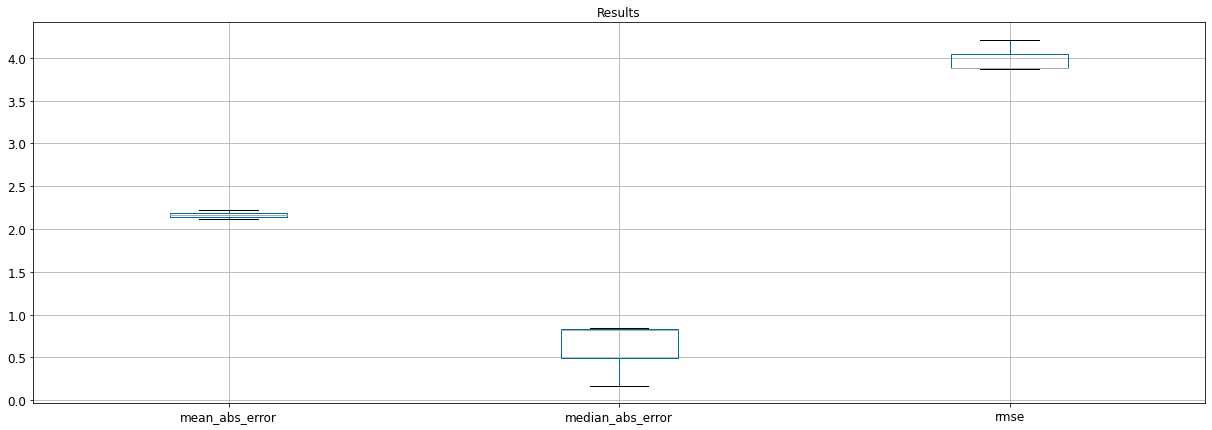

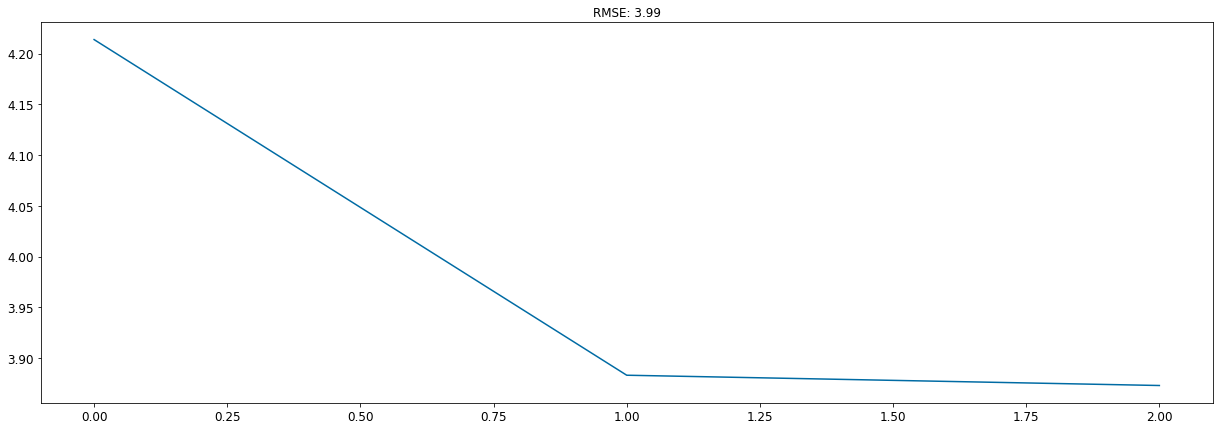

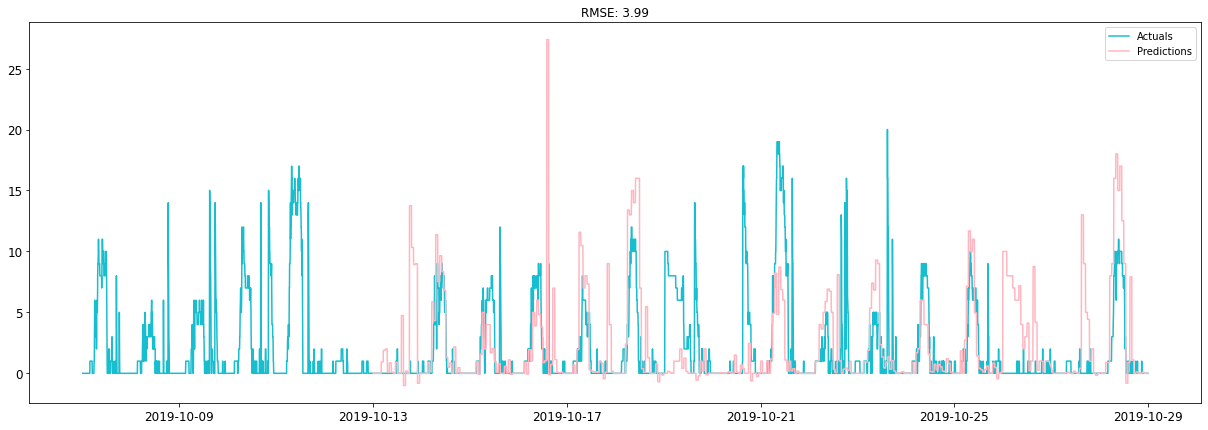

In [28]:
# Generate rolling predictions and results for particle of interest

data = var_station.sort_index().copy()
target = var_interest

fit_func = fit_autoARIMA
predict_func = predict_autoARIMA

min_train_date = '2019-10-07'

week_starts = pd.date_range(min_train_date, data.index.max(), freq='W')

predictions_over_time, results_over_time = [], []

for i, week_start in enumerate(week_starts):
    if i % 10 == 0:
        print(week_start)

    train_set = data.loc[:(week_start - timedelta(hours=1))]
    test_set = data.loc[week_start:(week_start + timedelta(weeks=1, hours=-1))]
    models = train_set.groupby(['weekday', 'hour'])[target].apply(fit_func)
    predictions = test_set.apply(lambda x: predict_func(models.loc[tuple(x[['weekday', 'hour']])], x), axis=1)
    predictions_over_time.append(predictions)    
    results = evaluate_forecast(test_set[target], predictions, 'none')
    results['date'] = week_start
    results_over_time.append(results)  

results_over_time_08 = pd.DataFrame(results_over_time)
predictions_over_time_08 = pd.concat(predictions_over_time)

# Plot results statistics

results_over_time = results_over_time_08

fig, ax = plt.subplots(figsize=(21,7))
results_over_time.drop(['r2_score', 'mse'], axis=1).boxplot()
plt.title('Results')
plt.show()

# Plot RMSE overtime

fig, ax = plt.subplots(figsize=(21,7))
rmse_over_time = plt.plot(results_over_time['rmse'])
error = results_over_time['rmse'].mean()
plt.title('RMSE: %.2f'% error)
plt.show()

# Plot actuals and predictions overtime

plot_actuals_predictions(var_station[var_interest][min_train_date:], predictions_over_time_08, results_over_time_08)

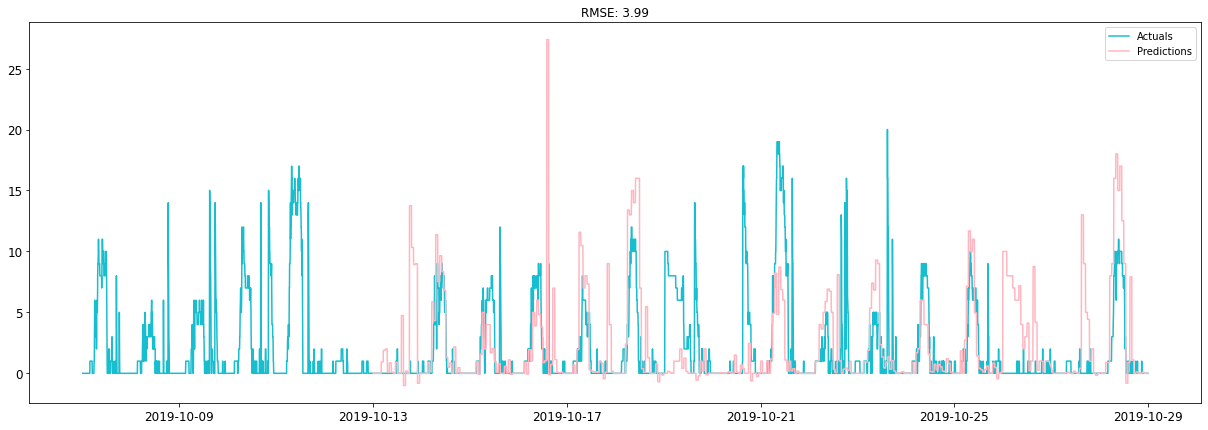

In [29]:
plot_actuals_predictions(var_station[var_interest][min_train_date:], predictions_over_time_08, results_over_time_08)

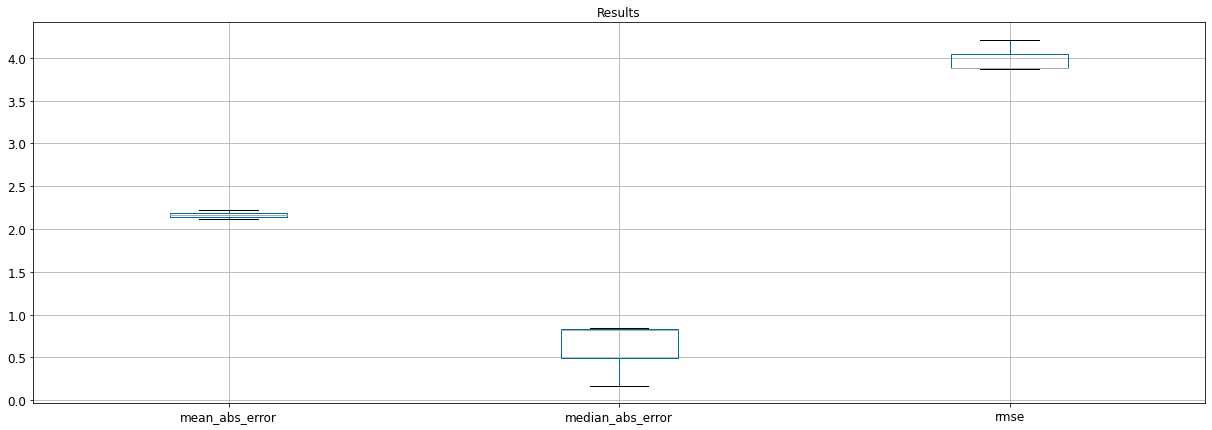

In [30]:
fig, ax = plt.subplots(figsize=(21,7))
results_over_time.drop(['r2_score', 'mse'], axis=1).boxplot()
plt.title('Results')
plt.show()

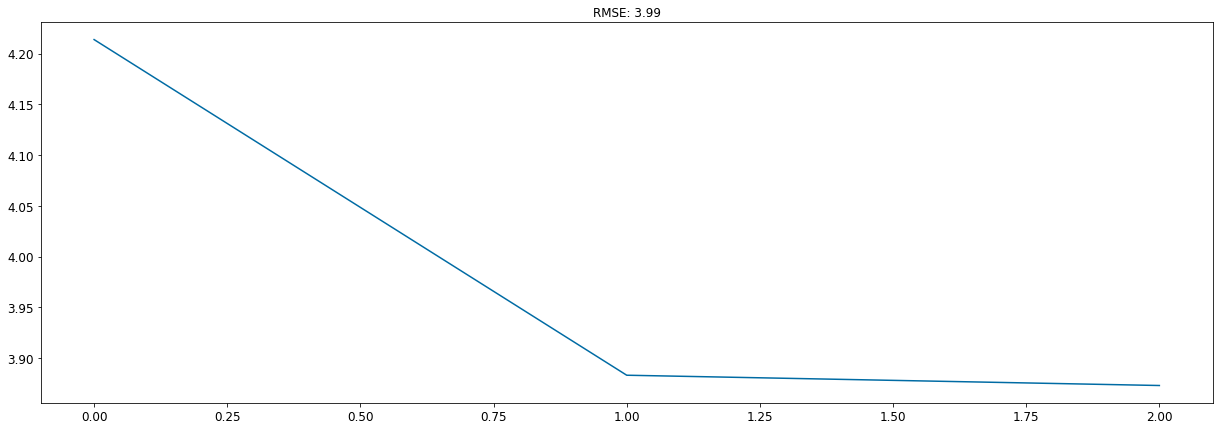

In [31]:
fig, ax = plt.subplots(figsize=(21,7))
rmse_over_time = plt.plot(results_over_time['rmse'])
error = results_over_time['rmse'].mean()
plt.title('RMSE: %.2f'% error)
plt.show()

In [32]:
results_over_time_08

,models,r2_score,mean_abs_error,median_abs_error,mse,rmse,date
0,none,-0.933730,2.221645,0.844044,17.755515,4.213729,2019-10-13
1,none,-0.056928,2.162551,0.819953,15.078133,3.883057,2019-10-20
2,none,-0.799295,2.112945,0.171513,14.999576,3.872929,2019-10-27


In [33]:
var_interest = 'num_bikes_available'
station_331 = 331

var_station_331 = df_select.loc[df_select['station_id'] == station_331]
var_station_331 = var_station_331.drop(columns = [x for x in data_of_interest if x is not var_interest], axis=1)
var_station_331.drop('station_id', axis=1, inplace=True)

station_183 = 183

var_station_183 = df_select.loc[df_select['station_id'] == station_183]
var_station_183 = var_station_183.drop(columns = [x for x in data_of_interest if x is not var_interest], axis=1)
var_station_183.drop('station_id', axis=1, inplace=True)

station_126 = 126

var_station_126 = df_select.loc[df_select['station_id'] == station_126]
var_station_126 = var_station_126.drop(columns = [x for x in data_of_interest if x is not var_interest], axis=1)
var_station_126.drop('station_id', axis=1, inplace=True)

station_102 = 102

var_station_102 = df_select.loc[df_select['station_id'] == station_102]
var_station_102 = var_station_102.drop(columns = [x for x in data_of_interest if x is not var_interest], axis=1)
var_station_102.drop('station_id', axis=1, inplace=True)

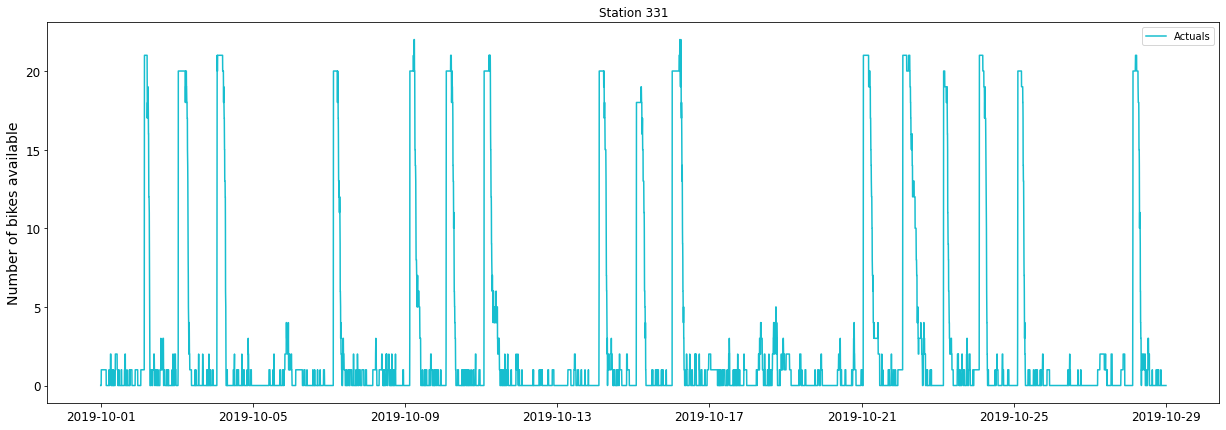

In [34]:
fig, ax = plt.subplots(figsize=(21,7))
actuals_331 = plt.plot(var_station_331, label='Actuals', color='tab:cyan')

# predictions = plt.plot(predictions_final, label='Predictions', color='lightpink')
# error = results_df['rmse'].mean()
plt.legend(loc='best')
# plt.title('RMSE: %.2f'% error)
plt.ylabel('Number of bikes available')
plt.title('Station 331')
plt.show()

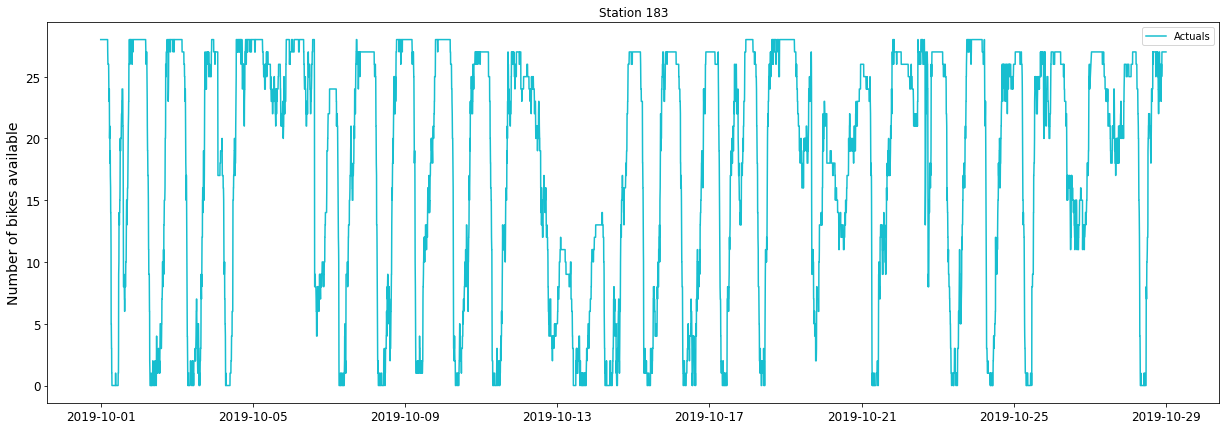

In [35]:
fig, ax = plt.subplots(figsize=(21,7))
actuals_183 = plt.plot(var_station_183, label='Actuals', color='tab:cyan')

# predictions = plt.plot(predictions_final, label='Predictions', color='lightpink')
# error = results_df['rmse'].mean()
plt.legend(loc='best')
plt.ylabel('Number of bikes available')
plt.title('Station 183')
# plt.title('RMSE: %.2f'% error)
plt.show()

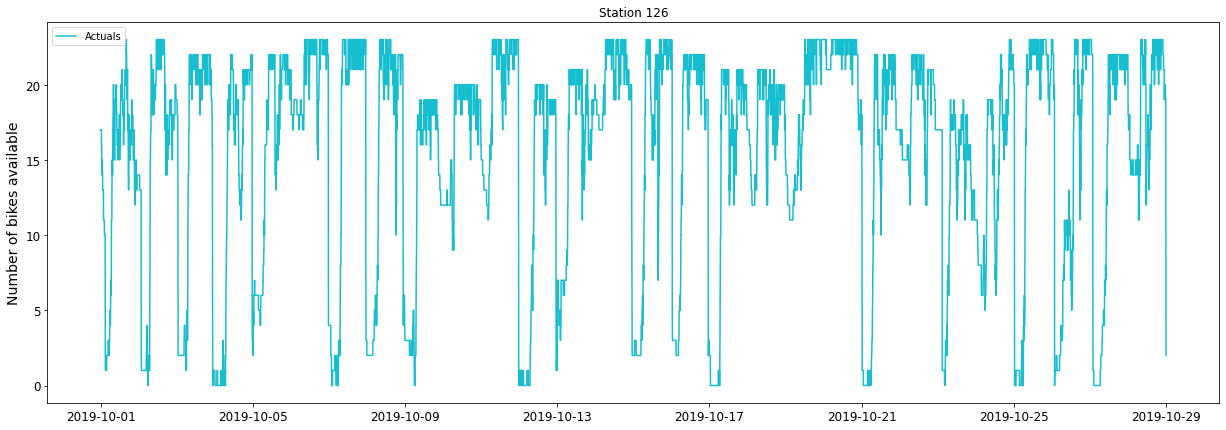

In [36]:
fig, ax = plt.subplots(figsize=(21,7))
actuals_126 = plt.plot(var_station_126, label='Actuals', color='tab:cyan')

# predictions = plt.plot(predictions_final, label='Predictions', color='lightpink')
# error = results_df['rmse'].mean()
plt.legend(loc='best')
plt.ylabel('Number of bikes available')
plt.title('Station 126')
# plt.title('RMSE: %.2f'% error)
plt.show()

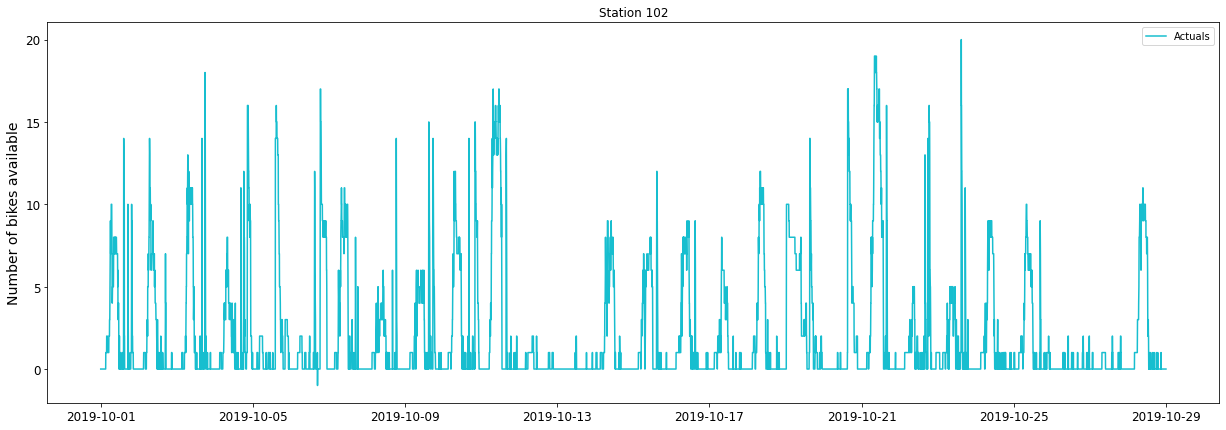

In [37]:
fig, ax = plt.subplots(figsize=(21,7))
actuals_102 = plt.plot(var_station_102, label='Actuals', color='tab:cyan')

# predictions = plt.plot(predictions_final, label='Predictions', color='lightpink')
# error = results_df['rmse'].mean()
plt.legend(loc='best')
plt.ylabel('Number of bikes available')
plt.title('Station 102')
# plt.title('RMSE: %.2f'% error)
plt.show()

Time series methods are widely used to predict one-dimensional data. Weekly predictions using ARIMA models have showed pretty accurate results for those stations that have a very similar pattern every week. However, the model doesn’t take into account variations such as protests or bank holidays, among other features.